# Macroeconomics Model:
## The Extenden solow model With human kapital and the incorpuration of AI as a vriable and two labor forces L_1 and L_2.
## Further development of the labour function; Extending the labour function with to different labor forces

In [1]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from sympy import symbols, Piecewise, diff


## Setting Up the main Macroeconomic model fo sumulations:

In [2]:

class MacroeconomicModel:
    def __init__(self, 
                 alpha=1/3,    # Output elasticity of capital
                 varphi=1/3,   # Output elasticity of human capital 
                 s_K=0.12,     # Savings rate for physical capital likke mellem 0 og 1 og sumen for alle s_
                 s_H=0.12,     # Savings rate for human capital
                 s_M=0.16,     # Assuming savings rate for AI is the same as for physical and human capital/should test
                 delta=0.05,   # Depreciation rate for physical and human capital and AI
                 n=0.01,       # Population growth rate
                 g=0.02,       # Technological growth rate
                 sigma=0.7,    # Importance parameter for labor vs. AI
                 
                 # New CES function parameters
                 alpha_11=0.5, # Share parameter for Intellectual-type la 
                 alpha_12=0.5, # Share parameter for AI in L_1
                 alpha_21=0.5, # Share parameter for physical-type labor 
                 alpha_22=0.5, # Share parameter for AI in L_2
                 alpha_31=0.5, # Share parameter for L_1 in effective labor
                 alpha_32=0.5, # Share parameter for L_2 in effective labor
                 
                 # New CES function Elasticities
                 eta_1=1.4,    # Elasticity of substitution between AL1 and M (Intellectual -type labor)- kig på 0 eller 1 og måske mere
                 eta_2=0.4,    # Elasticity of substitution between AL2 and M (physical-type labor)
                 eta_3=0.4):   # Elasticity of substitution between L_1 and L_2 its between the two types of workforces

        
        # Cap for the total savings rate book page 349
        savings_cap = 0.50
        # Calculate the total savings rate
        total_savings = s_K + s_H + s_M
        # Adjust savings rates if the total exceeds the cap
        if total_savings > savings_cap:
            excess = total_savings - savings_cap
            adjustment = excess / 2
            # Adjust the two other savings rates
            if s_K == max(s_K, s_H, s_M):
                s_H = max(0, s_H - adjustment)
                s_M = max(0, s_M - adjustment)
            elif s_H == max(s_K, s_H, s_M):
                s_K = max(0, s_K - adjustment)
                s_M = max(0, s_M - adjustment)
            else:  # s_M is the highest
                s_K = max(0, s_K - adjustment)
                s_H = max(0, s_H - adjustment)
            # Print a notification
            print("Total savings rate exceeded the cap. Adjusting s_K, s_H, and s_M to comply with the cap.")
            print(s_K)
            print(s_H)
            print(s_M)
            
        
        self.alpha = alpha
        self.varphi = varphi
        self.s_K = s_K
        self.s_H = s_H
        self.s_M = s_M
        self.delta = delta
        self.n = n
        self.g = g
        self.sigma = sigma
        self.alpha_11 = alpha_11
        self.alpha_12 = alpha_12
        self.alpha_21 = alpha_21
        self.alpha_22 = alpha_22
        self.alpha_31 = alpha_31
        self.alpha_32 = alpha_32
        self.eta_1 = eta_1
        self.eta_2 = eta_2
        self.eta_3 = eta_3
    
    ## Helper function to calculate effective labor
    @staticmethod
    def effective_labor(AL1_t, AL2_t, M_t, alpha_11, alpha_12, alpha_21, alpha_22, alpha_31, alpha_32, eta_1, eta_2, eta_3):
        # Check if M is zero and adjust the CES functions accordingly
        if M_t == 0:
            L_1 = AL1_t  # When M is zero, L_1 is just AL1_t
            L_2 = AL2_t  # When M is zero, L_2 is just AL2_t
        else:
            L_1 = (alpha_11 * (AL1_t)**(eta_1-1) + (alpha_12 * (M_t)**(eta_1-1)))**(1/(eta_1-1))#(Intellectual -type labor)
            L_2 = (alpha_21 * (AL2_t)**(eta_2-1) + (alpha_22 * (M_t)**(eta_2-1)))**(1/(eta_2-1))#(physical-type labor)
        # Handle the Cobb-Douglas case (eta_3 = 1)
        if eta_3 == 1:
            EffectiveLabor_t = alpha_31 * L_1 + alpha_32 * L_2
        else:
            EffectiveLabor_t = (alpha_31 * (L_1)**(eta_3-1) + alpha_32 * (L_2)**(eta_3-1))**(1/(eta_3-1))#(Cimbination of Intellectual and physical labor)
        return EffectiveLabor_t
    
    def calculate_steady_state(self):
        # Calculate steady-state capital per effective worker
        k_tilde_ss = (self.s_K / (self.n + self.g + self.delta + self.n * self.g))**(1 / (1 - self.alpha))
        # Calculate steady-state output per effective worker
        y_tilde_ss = (self.s_K / (self.n + self.g + self.delta + self.n * self.g))**(self.alpha / (1 - self.alpha))
        
        return k_tilde_ss, y_tilde_ss



    
    ## Complete the simulation loop
    def simulate(self, K_0, H_0, L_0, A_0, M_0, T):
        # Define the symbols for SymPy
        AL1, AL2, M, alpha_11, alpha_12, alpha_21, alpha_22, alpha_31, alpha_32, eta_1, eta_2, eta_3 = sp.symbols('AL1 AL2 M alpha_11 alpha_12 alpha_21 alpha_22 alpha_31 alpha_32 eta_1 eta_2 eta_3')

        ## Define the effective labor components L_1 and L_2 using your CES functions and being able to handle ZER0 values:
        L_1_sym = Piecewise(
            ((alpha_11 * AL1**(eta_1-1) + alpha_12 * M**(eta_1-1))**(1/(eta_1-1)), M != 0),
            (AL1, True)  # If M is zero, L_1 is just AL1
        )
        
        L_2_sym = Piecewise(
            ((alpha_21 * AL2**(eta_2-1) + alpha_22 * M**(eta_2-1))**(1/(eta_2-1)), M != 0),
            (AL2, True)  # If M is zero, L_2 is just AL2
        )
       
        ## Calculate the derivatives of L_1 and L_2 with respect to AL1 and AL2.(Marginal Product of Labor (MPL))
        MPL_L1_sym = sp.diff(L_1_sym, AL1)
        MPL_L2_sym = sp.diff(L_2_sym, AL2)

        
        ## Create lambda functions for the marginal products
        ##convert symbolic expressions for the marginal products of L_1 and L_2 into callable functions that can be evaluated numerically.
        mpl_L1_func = sp.lambdify((AL1, M, alpha_11, alpha_12, eta_1), MPL_L1_sym, "numpy")
        mpl_L2_func = sp.lambdify((AL2, M, alpha_21, alpha_22, eta_2), MPL_L2_sym, "numpy")
        # Redefine the lambda functions to handle M being zero
        def safe_mpl_L1_func(AL1, M, alpha_11, alpha_12, eta_1):
            if M == 0:
                return AL1  # Return the marginal product when M is zero
            else:
                return mpl_L1_func(AL1, M, alpha_11, alpha_12, eta_1)

        def safe_mpl_L2_func(AL2, M, alpha_21, alpha_22, eta_2):
            if M == 0:
                return AL2  # Return the marginal product when M is zero
            else:
                return mpl_L2_func(AL2, M, alpha_21, alpha_22, eta_2)        

        
        ## Arrays to store the simulation results
        K, H, L, A, M, Y, r, w, w_L1, w_L2 = np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T)
        K[0], H[0], L[0], A[0], M[0] = K_0, H_0, L_0, A_0, M_0
        

        for t in range(T-1):
            ## Calculate effective labor at time t
            ## For simplicity, assuming AL1 = AL2 = A * L * (0.5) becuase halv of the labor force goes to L_1, the other to L_2
            AL1_t = A[t] * L[t] * (0.5)
            AL2_t = A[t] * L[t] * (1-0.5)

            ## Use the lambda functions to evaluate the marginal products for L_1 and L_2 at time t.
            mpl_L1_t = safe_mpl_L1_func(AL1_t, M[t], self.alpha_11, self.alpha_12, self.eta_1)
            mpl_L2_t = safe_mpl_L2_func(AL2_t, M[t], self.alpha_21, self.alpha_22, self.eta_2)

            ## Assuming the price of output is normalized to 1, otherwise multiply by the price
            w_L1[t] = mpl_L1_t  # Numerical value of the marginal product of labor L1
            w_L2[t] = mpl_L2_t  # Numerical value of the marginal product of labor L2
    
            
            
            EffectiveLabor_t = self.effective_labor(AL1_t, AL2_t, M[t], self.alpha_11, self.alpha_12, self.alpha_21, self.alpha_22, self.alpha_31, self.alpha_32, self.eta_1, self.eta_2, self.eta_3)
            
            ## Production function
            Y[t] = (K[t]**self.alpha) * (H[t]**self.varphi) * (EffectiveLabor_t**(1-self.alpha-self.varphi))
            
            ## Calculate return to capital and wage rates
            r[t] = self.alpha * Y[t] * (K[t]/Y[t])**(1-self.alpha)
            w[t] = (1-self.alpha) * Y[t] *(EffectiveLabor_t/Y[t])**((self.sigma-1-self.alpha)/self.sigma)
            

            ## Update next period's capital, human capital, labor, technology, and AI levels
            K[t+1] = K[t] + self.s_K * Y[t] - self.delta * K[t]
            H[t+1] = H[t] + self.s_H * Y[t] - self.delta * H[t]
            M[t+1] = M[t] + self.s_M * Y[t] - self.delta * M[t]
            L[t+1] = L[t] * (1 + self.n)
            A[t+1] = A[t] * (1 + self.g)
            
        ## Calculate the output, return to capital, and wage rate for the final year
        AL1_t = A[-1] * L[-1] * 0.5
        AL2_t = A[-1] * L[-1] * (1-0.5)

        EffectiveLabor_t = self.effective_labor(AL1_t, AL2_t, M[-1], self.alpha_11, self.alpha_12, self.alpha_21, self.alpha_22, self.alpha_31, self.alpha_32, self.eta_1, self.eta_2, self.eta_3)

        Y[-1] = (K[-1]**self.alpha) * (H[-1]**self.varphi) * (EffectiveLabor_t**(1-self.alpha-self.varphi))
        r[-1] = self.alpha * Y[-1] * (K[-1]/Y[-1])**(1-self.alpha)
        w[-1] = (1-self.alpha) * Y[-1] *(EffectiveLabor_t/Y[-1])**((self.sigma-1-self.alpha)/self.sigma)
        
        mpl_L1_t = safe_mpl_L1_func(AL1_t, M[-1], self.alpha_11, self.alpha_12, self.eta_1)
        mpl_L2_t = safe_mpl_L1_func(AL2_t, M[-1], self.alpha_21, self.alpha_22, self.eta_2)
        w_L1[-1] = mpl_L1_t
        w_L2[-1] = mpl_L2_t

        df = pd.DataFrame({'Capital': K, 'Human Capital': H, 'Labor': L, 'Technology': A, 'AI': M, 'Output': Y, 
                           'Return to Capital': r, 'Wage Rate': w, 'Wage Rate L1': w_L1, 'Wage Rate L2': w_L2})
        return df




In [3]:
# Create an instance of the model
model = MacroeconomicModel()

# Calculate steady-state values
k_ss, y_ss = model.calculate_steady_state()

# Output the results
print(f"Steady-state capital per effective worker: {k_ss}")
print(f"Steady-state output per effective worker: {y_ss}")


Steady-state capital per effective worker: 1.8302495832882708
Steady-state output per effective worker: 1.2232168048309946


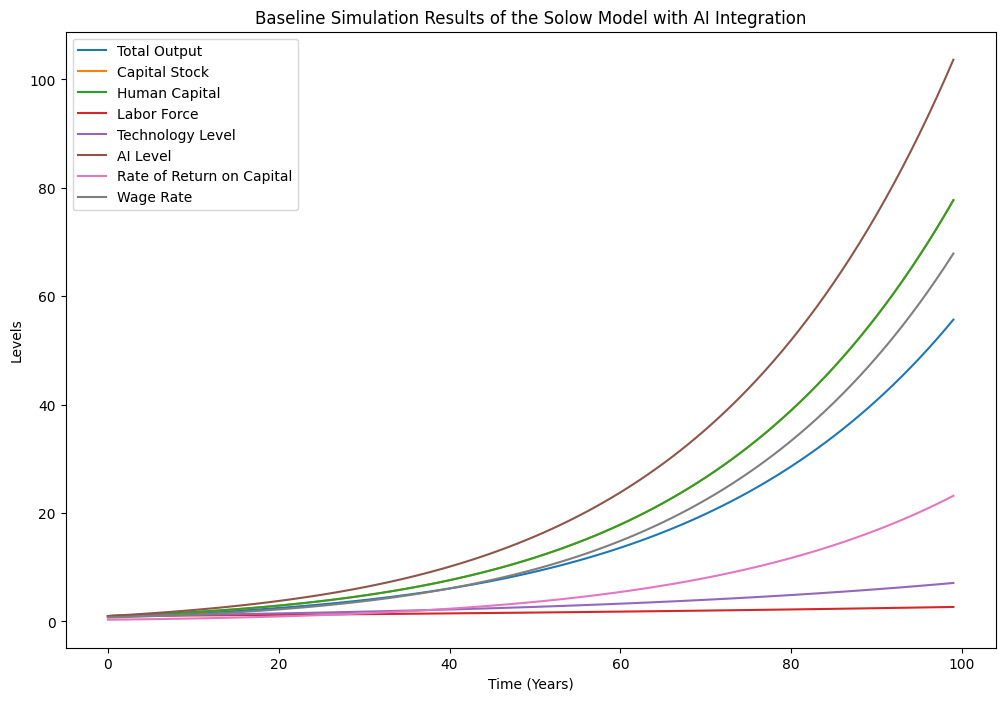

In [4]:
import matplotlib.pyplot as plt

# Assuming you have already created an instance of the class and run a simulation
model = MacroeconomicModel()
results = model.simulate(K_0=1, H_0=1, L_0=1, A_0=1, M_0=1, T=100)

# Plotting the results from the DataFrame ne model
plt.figure(figsize=(12, 8))
plt.plot(results['Output'], label='Total Output')
plt.plot(results['Capital'], label='Capital Stock')
plt.plot(results['Human Capital'], label='Human Capital')
plt.plot(results['Labor'], label='Labor Force')
plt.plot(results['Technology'], label='Technology Level')
plt.plot(results['AI'], label='AI Level')
plt.plot(results['Return to Capital'], label='Rate of Return on Capital')
plt.plot(results['Wage Rate'], label='Wage Rate')
plt.title('Baseline Simulation Results of the Solow Model with AI Integration')
plt.xlabel('Time (Years)')
plt.ylabel('Levels')
plt.legend()
plt.show()

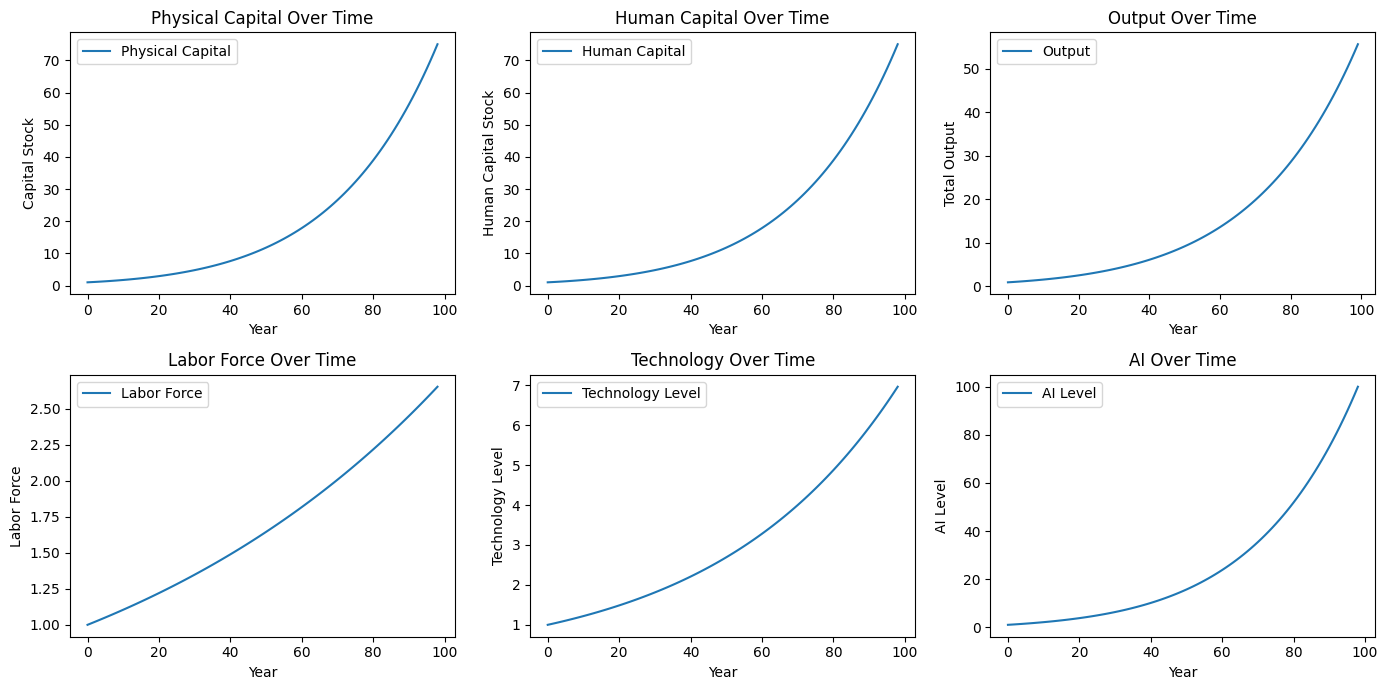

In [5]:
# Initialize model with the desired parameters
model = MacroeconomicModel()

# Run the simulation with initial conditions and time horizon
results = model.simulate(K_0=1, H_0=1, L_0=1, A_0=1, M_0=1, T=100)

# Now results is a DataFrame with all the simulation data
# Plot the results using DataFrame columns
plt.figure(figsize=(14, 7))

plt.subplot(2, 3, 1)
plt.plot(results['Capital'][:-1], label='Physical Capital')
plt.title('Physical Capital Over Time')
plt.xlabel('Year')
plt.ylabel('Capital Stock')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(results['Human Capital'][:-1], label='Human Capital')
plt.title('Human Capital Over Time')
plt.xlabel('Year')
plt.ylabel('Human Capital Stock')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(results['Output'], label='Output')
plt.title('Output Over Time')
plt.xlabel('Year')
plt.ylabel('Total Output')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(results['Labor'][:-1], label='Labor Force')
plt.title('Labor Force Over Time')
plt.xlabel('Year')
plt.ylabel('Labor Force')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(results['Technology'][:-1], label='Technology Level')
plt.title('Technology Over Time')
plt.xlabel('Year')
plt.ylabel('Technology Level')
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(results['AI'][:-1], label='AI Level')
plt.title('AI Over Time')
plt.xlabel('Year')
plt.ylabel('AI Level')
plt.legend()

plt.tight_layout()
plt.show()


## Calculates the growth rates of over a time Period T

In [6]:
## Calculates the growth rates of over a time peropd T
# Function to run simulation and plot results

In [7]:
# Corrected function to run simulation and plot results
def run_simulation(T):
    # Initialize the model
    model = MacroeconomicModel()
    
    # Run the simulation
    results = model.simulate(K_0=1, H_0=1, L_0=1, A_0=1, M_0=1, T=T)
    
    # Calculate growth rates on a per labor unit basis
    results['Y_per_capita'] = results['Output'] / results['Labor']
    results['K_per_capita'] = results['Capital'] / results['Labor']
    results['H_per_capita'] = results['Human Capital'] / results['Labor']
    results['M_per_capita'] = results['AI'] / results['Labor']
    
    results['Y_growth'] = results['Y_per_capita'].pct_change().fillna(0)
    results['K_growth'] = results['K_per_capita'].pct_change().fillna(0)
    results['H_growth'] = results['H_per_capita'].pct_change().fillna(0)
    results['M_growth'] = results['M_per_capita'].pct_change().fillna(0)
    
    # Shows the numbers the last five years
    print("Growth Rate for Output per capita in the last 5 years:", results['Y_growth'][-5:])
    print("Growth Rate for Capital per capita in the last 5 years:", results['K_growth'][-5:])
    print("Growth Rate for Human Capital per capita in the last 5 years:", results['H_growth'][-5:])
    print("Growth Rate for AI per capita in the last 5 years:", results['M_growth'][-5:])
    
    
    # Plot growth rates starting from year one (index 1)
    plt.figure(figsize=(12, 8))
    plt.plot(results.index[1:], results['Y_growth'][1:], label='Growth Rate for Output per Capita')  # Start from index 1
    plt.plot(results.index[1:], results['K_growth'][1:], label='Growth Rate for Capital per Capita')  # Start from index 1
    plt.plot(results.index[1:], results['H_growth'][1:], label='Growth Rate for Human Capital per Capita')  # Start from index 1
    plt.plot(results.index[1:], results['M_growth'][1:], label='Growth Rate for AI Capital per Capita')  # Start from index 1
    
    plt.title('Per Capita Growth Rates Over Time')
    plt.xlabel('Time (Years)')
    plt.ylabel('Growth Rate')
    plt.legend()
    plt.show()

    
     # Add code to find the first year when Y_growth is exactly 0.02
    target_growth_rate = 0.020
    tolerance = 1e-6  # A small tolerance for floating-point comparison
    year_of_exact_target_growth = None
    for index, growth_rate in results['Y_growth'].iteritems():  # Use iteritems to get the index and value
        if abs(growth_rate - target_growth_rate) < tolerance:
            year_of_exact_target_growth = index  # index here corresponds to the year in the simulation
            break
    # Check if the target growth rate was exactly met within the simulation period
    if year_of_exact_target_growth is not None:
        print(f"Per Capita Growth Rate for Output exactly hit {target_growth_rate} in year {year_of_exact_target_growth}.")
    else:
        print(f"Per Capita Growth Rate for Output did not exactly hit {target_growth_rate} within the simulation period.")
    
    
    
# Widget to adjust the number of years
T_slider = widgets.IntSlider(min=1, max=1000, step=1, value=250, description='Amount of years (T):')
w = widgets.interactive(run_simulation, T=T_slider)
display(w)

interactive(children=(IntSlider(value=250, description='Amount of years (T):', max=1000, min=1), Output()), _d…

## Growth rates over a time period T with different levels of $s_m$

Total savings rate exceeded the cap. Adjusting s_K, s_H, and s_M to comply with the cap.
0.09999999999999998
0.09999999999999998
0.3
Total savings rate exceeded the cap. Adjusting s_K, s_H, and s_M to comply with the cap.
0.07500000000000001
0.07500000000000001
0.35


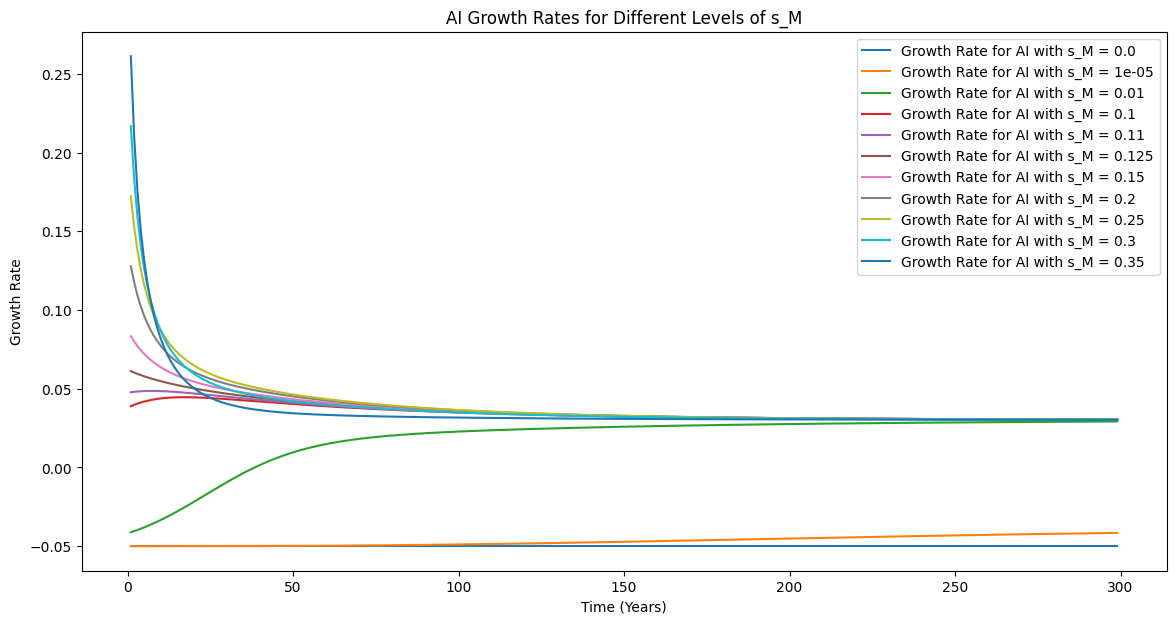

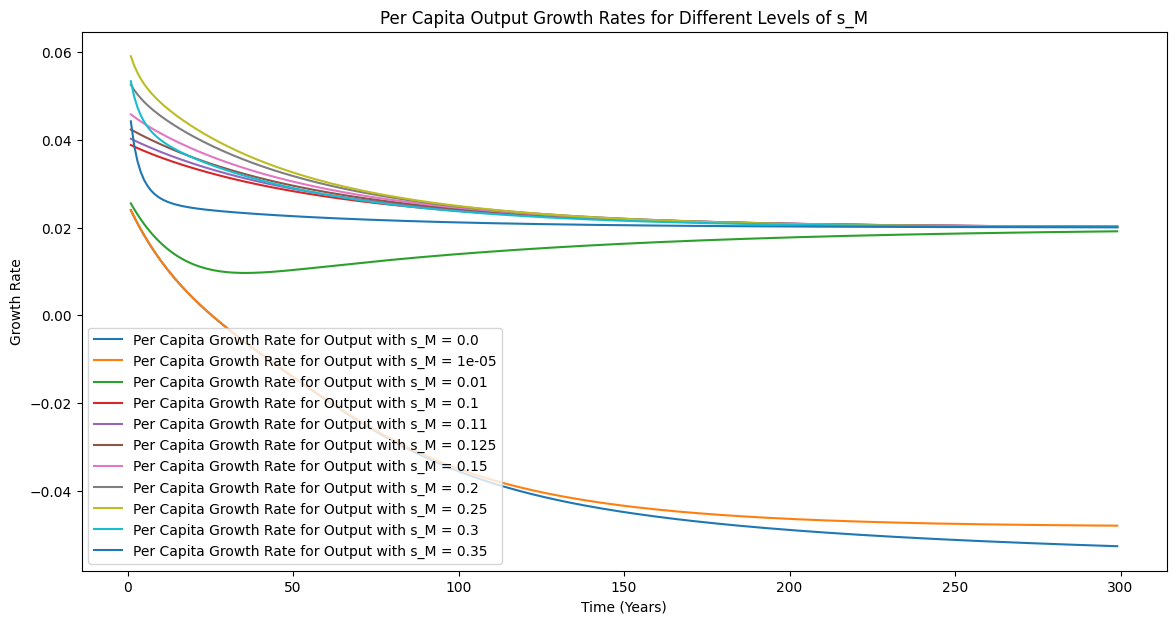

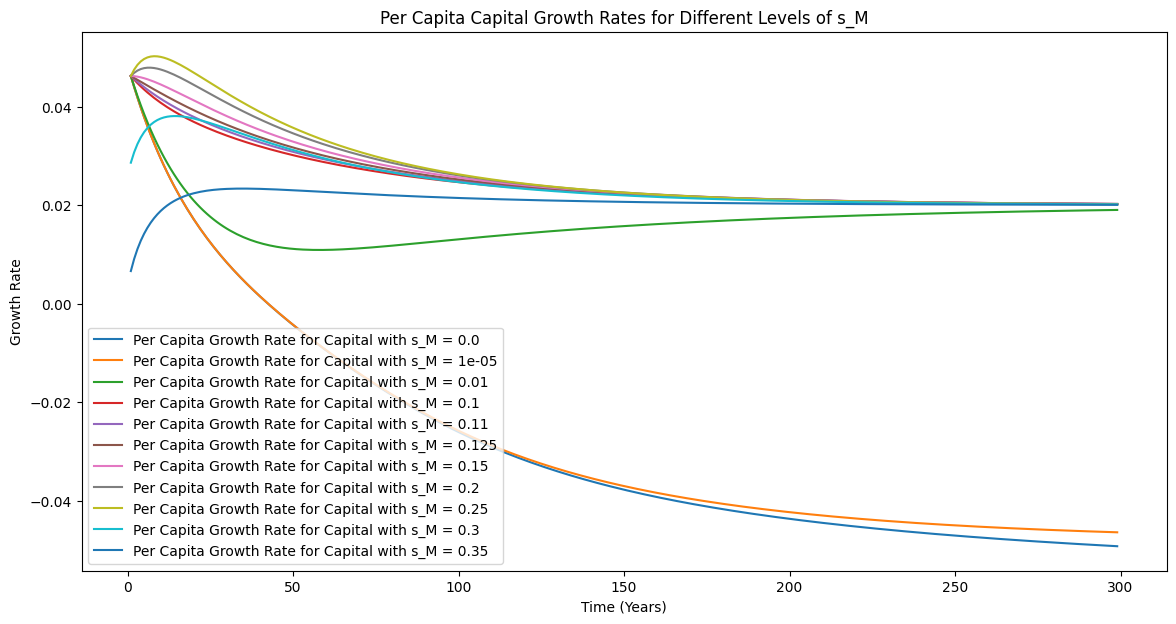

In [8]:
def simulate_different_s_M(s_M_values, T):
    growth_rates_M = {}
    growth_rates_Y = {}
    growth_rates_K = {}

    for s_M in s_M_values:
        model = MacroeconomicModel(s_M=s_M)
        results = model.simulate(K_0=1, H_0=1, L_0=1, A_0=1, M_0=1, T=T)

        # Calculate per capita values     
        results['Y_per_capita'] = results['Output'] / results['Labor']
        results['K_per_capita'] = results['Capital'] / results['Labor']
        
        # Calculate growth rates for AI, Output per capita, and Capital per capita
        results['Y_growth'] = results['Y_per_capita'].pct_change().fillna(0)
        results['K_growth'] = results['K_per_capita'].pct_change().fillna(0)
        results['M_growth'] = results['AI'].pct_change().fillna(0)


        # Store the growth rates in their respective dictionaries
        growth_rates_M[s_M] = results['M_growth']
        growth_rates_Y[s_M] = results['Y_growth']
        growth_rates_K[s_M] = results['K_growth']

    # Plot for AI growth rates
    plt.figure(figsize=(14, 7))
    for s_M, rates in growth_rates_M.items():
        plt.plot(rates[1:], label=f'Growth Rate for AI with s_M = {s_M}')
    plt.title('AI Growth Rates for Different Levels of s_M')
    plt.xlabel('Time (Years)')
    plt.ylabel('Growth Rate')
    plt.legend()
    plt.show()

    # Plot for Output growth rates
    plt.figure(figsize=(14, 7))
    for s_M, rates in growth_rates_Y.items():
        plt.plot(rates[1:], label=f'Per Capita Growth Rate for Output with s_M = {s_M}')
    plt.title('Per Capita Output Growth Rates for Different Levels of s_M')
    plt.xlabel('Time (Years)')
    plt.ylabel('Growth Rate')
    plt.legend()
    plt.show()

    # Plot for Capital growth rates
    plt.figure(figsize=(14, 7))
    for s_M, rates in growth_rates_K.items():
        plt.plot(rates[1:], label=f'Per Capita Growth Rate for Capital with s_M = {s_M}')
    plt.title('Per Capita Capital Growth Rates for Different Levels of s_M')
    plt.xlabel('Time (Years)')
    plt.ylabel('Growth Rate')
    plt.legend()
    plt.show()
    
    
    
    

# Call the function with your desired s_M values and time horizon
simulate_different_s_M([0.0, 0.00001 , 0.01, 0.10, 0.11, 0.125, 0.15, 0.20, 0.25, 0.30, 0.35], T=300)




# mnår man har en lille opsparing i maskinelæring er den negativ for AI growth levels?????
# hvorfor er de negative til at starte med i den første graph
# der er nogle sjove ting ved grænsetilfælde graf nr 2

## Steady-State Growth Rate vs. Savings Rate for AI (s_M)


Total savings rate exceeded the cap. Adjusting s_K, s_H, and s_M to comply with the cap.
0.11318181818181816
0.11318181818181816
0.2736363636363636
Total savings rate exceeded the cap. Adjusting s_K, s_H, and s_M to comply with the cap.
0.09999999999999998
0.09999999999999998
0.3


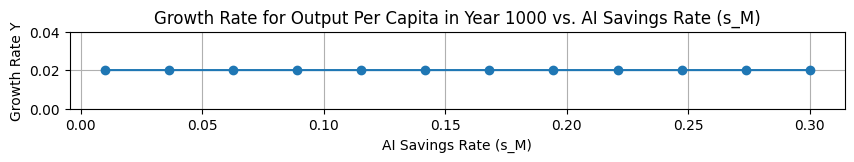

In [9]:
# Define the range of s_M values
s_M_values = np.linspace(0.01, 0.30, 12)  # Adjust as needed
growth_rates = []

# Iterate over s_M values
for s_M in s_M_values:
    # Initialize the model with the current s_M value
    model = MacroeconomicModel(s_M=s_M)
    
    # Run the simulation until year 1000
    results = model.simulate(K_0=1, H_0=1, L_0=1, A_0=1, M_0=1, T=1000)
    
    # Calculate output per capita
    results['Y_per_capita'] = results['Output'] / results['Labor']
    
    # Calculate growth rate for output per capita in the last year
    growth_rate = results['Y_per_capita'].pct_change().iloc[-1]
    
    #print("Growth Rate for Output per capita in the last 5 years:", results['Y_growth'][-1:])
    # Store the growth rate
    growth_rates.append(growth_rate)

# Plotting the results
plt.figure(figsize=(10, 1))
plt.plot(s_M_values, growth_rates, marker='o')
plt.title('Growth Rate for Output Per Capita in Year 1000 vs. AI Savings Rate (s_M)')
plt.xlabel('AI Savings Rate (s_M)')
plt.ylabel('Growth Rate Y')
plt.ylim(0, 0.04)
plt.grid(True)
plt.show()


# Uzawa's theorem

# Wage Tests

In [10]:
# Run the simulation
def run_simulation(T):
    model = MacroeconomicModel()
    results = model.simulate(K_0=1, H_0=1, L_0=1, A_0=1, M_0=1, T=T)

    # Calculate wage growth rates using the pct_change method on the DataFrame
    results['Wage Growth L1'] = results['Wage Rate L1'].pct_change().fillna(0)
    results['Wage Growth L2'] = results['Wage Rate L2'].pct_change().fillna(0)

    # Calculate the ratio of L1 to L2 wages
    results['Wage Ratio L1/L2'] = results['Wage Rate L1'] / results['Wage Rate L2']

    # Plot wages over time
    plt.figure(figsize=(16, 10))

    # Plot L1 and L2 wages
    plt.subplot(2, 2, 1)
    plt.plot(results.index, results['Wage Rate L1'], label='Wage L1')
    plt.plot(results.index, results['Wage Rate L2'], label='Wage L2')
    plt.title('Wages Rates over Time')
    plt.xlabel('Time (Years)')
    plt.ylabel('Wage Rate')
    plt.legend()

    # Plot wage growth rates
    plt.subplot(2, 2, 2)
    plt.plot(results.index, results['Wage Growth L1'], label='Growth Wage L1')
    plt.plot(results.index, results['Wage Growth L2'], label='Growth Wage L2')
    plt.title('Wage Growth Rates Over Time')
    plt.xlabel('Time (Years)')
    plt.ylabel('Growth Rate')
    plt.legend()

    # Plot the wage ratio
    plt.subplot(2, 2, 3)
    plt.plot(results.index, results['Wage Ratio L1/L2'], label='Wage Ratio L1/L2')
    plt.title('Wage Ratio L1/L2 Over Time')
    plt.xlabel('Time (Years)')
    plt.ylabel('Wage Ratio')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Widget to adjust the number of years
T_slider = widgets.IntSlider(min=1, max=1000, step=1, value=100, description='Amount of years (T):')
w = widgets.interactive(run_simulation, T=T_slider)
display(w)


interactive(children=(IntSlider(value=100, description='Amount of years (T):', max=1000, min=1), Output()), _d…

## Analysis of different levels of Elasticity of Substitution between labor and AI:

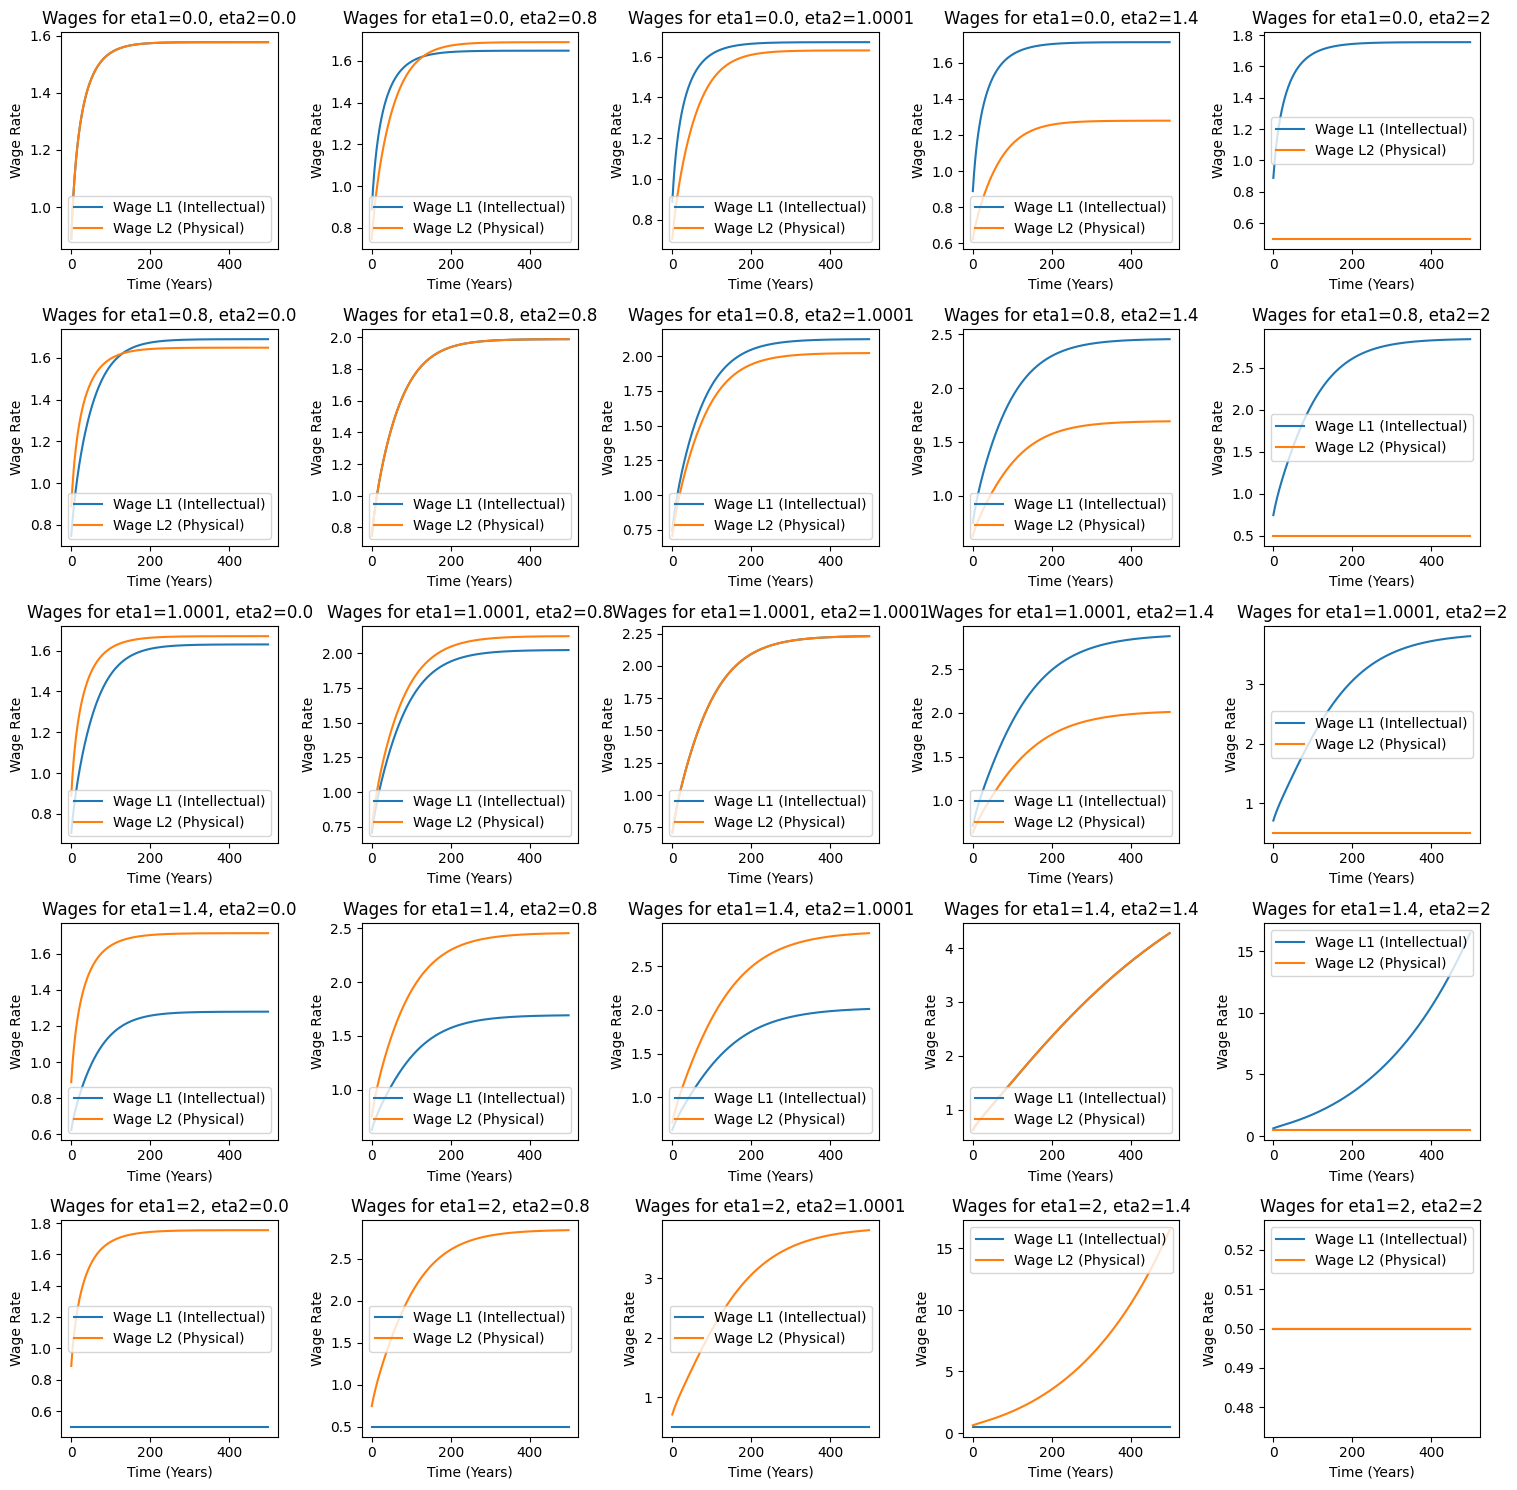

In [11]:
def test_elasticity_of_substitution(eta1_values, eta2_values, T):
    fig, ax = plt.subplots(len(eta1_values), len(eta2_values), figsize=(15, 15))
    
    # Check if we have a subplot grid or a single row/column
    if len(eta1_values) == 1 or len(eta2_values) == 1:
        ax = [ax]  # Make sure we can iterate over ax

    for i, eta1 in enumerate(eta1_values):
        for j, eta2 in enumerate(eta2_values):
            model = MacroeconomicModel(eta_1=eta1, eta_2=eta2)
            results = model.simulate(K_0=1, H_0=1, L_0=1, A_0=1, M_0=1, T=T)
            
            # Plotting the wage rates over time for each combination of eta1 and eta2
            if len(eta1_values) > 1 and len(eta2_values) > 1:
                ax_ij = ax[i, j]  # If we have a grid, select subplot
            elif len(eta1_values) > 1:
                ax_ij = ax[i]  # If we only vary eta1, select row
            else:
                ax_ij = ax[j]  # If we only vary eta2, select column

            ax_ij.plot(results['Wage Rate L1'], label='Wage L1 (Intellectual)')
            ax_ij.plot(results['Wage Rate L2'], label='Wage L2 (Physical)')
            ax_ij.set_title(f'Wages for eta1={eta1}, eta2={eta2}')
            ax_ij.set_xlabel('Time (Years)')
            ax_ij.set_ylabel('Wage Rate')
            ax_ij.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
test_elasticity_of_substitution([0.0, 0.8, 1.0001, 1.4, 2], [0.0, 0.8, 1.0001, 1.4, 2], 500)


                 #eta_1=Elasticity of substitution between AL1 and M (Intellectual -type labor)- kig på 0 eller 1 og måske mere
                 #eta_2=Elasticity of substitution between AL2 and M (physical-type labor)
                 #eta_3=Elasticity of substitution between L_1 and L_2 its between the two types of workforces
            

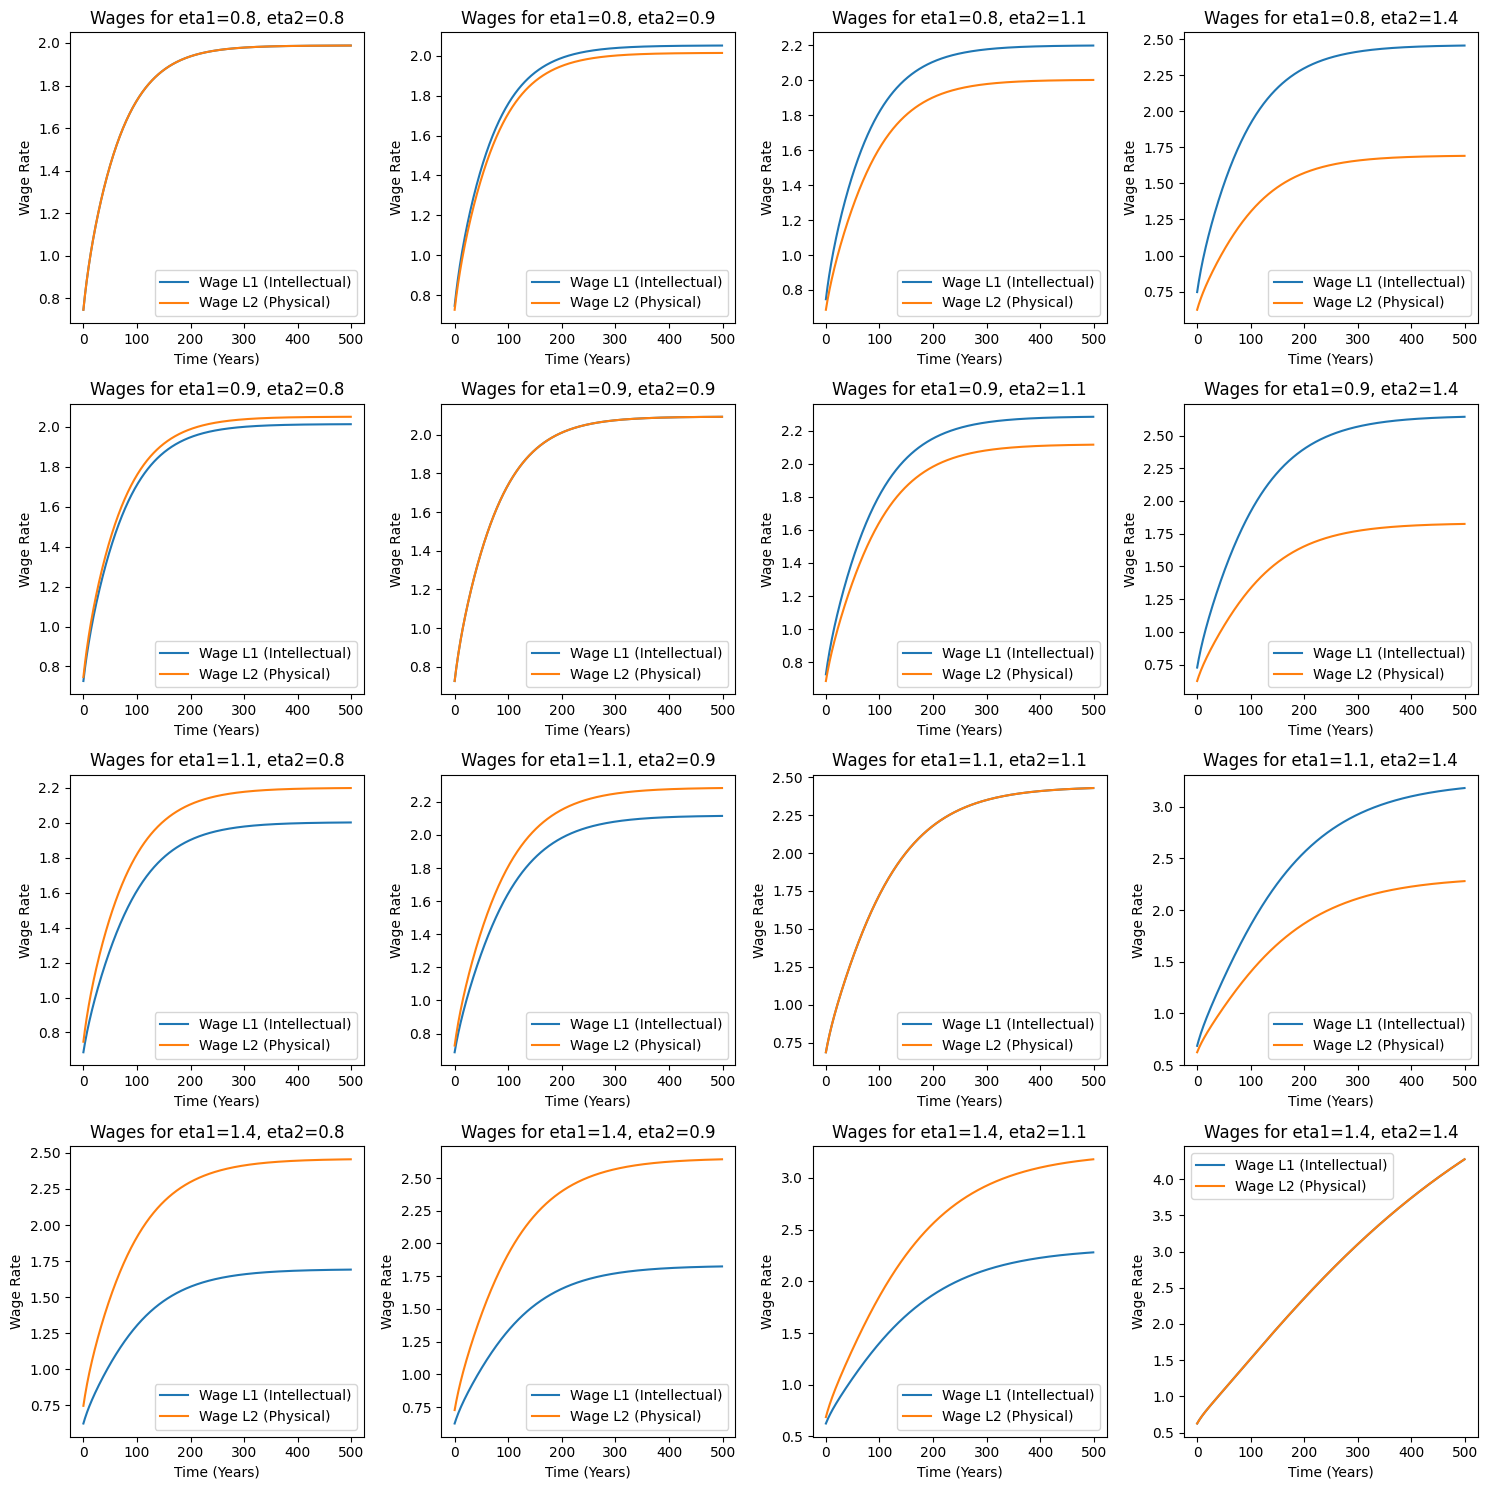

In [12]:
def test_elasticity_of_substitution(eta1_values, eta2_values, T):
    fig, ax = plt.subplots(len(eta1_values), len(eta2_values), figsize=(15, 15))
    
    # Check if we have a subplot grid or a single row/column
    if len(eta1_values) == 1 or len(eta2_values) == 1:
        ax = [ax]  # Make sure we can iterate over ax

    for i, eta1 in enumerate(eta1_values):
        for j, eta2 in enumerate(eta2_values):
            model = MacroeconomicModel(eta_1=eta1, eta_2=eta2)
            results = model.simulate(K_0=1, H_0=1, L_0=1, A_0=1, M_0=1, T=T)
            
            # Plotting the wage rates over time for each combination of eta1 and eta2
            if len(eta1_values) > 1 and len(eta2_values) > 1:
                ax_ij = ax[i, j]  # If we have a grid, select subplot
            elif len(eta1_values) > 1:
                ax_ij = ax[i]  # If we only vary eta1, select row
            else:
                ax_ij = ax[j]  # If we only vary eta2, select column

            ax_ij.plot(results['Wage Rate L1'], label='Wage L1 (Intellectual)')
            ax_ij.plot(results['Wage Rate L2'], label='Wage L2 (Physical)')
            ax_ij.set_title(f'Wages for eta1={eta1}, eta2={eta2}')
            ax_ij.set_xlabel('Time (Years)')
            ax_ij.set_ylabel('Wage Rate')
            ax_ij.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
test_elasticity_of_substitution([0.8, 0.9, 1.1, 1.4], [ 0.8, 0.9, 1.1, 1.4], 500)


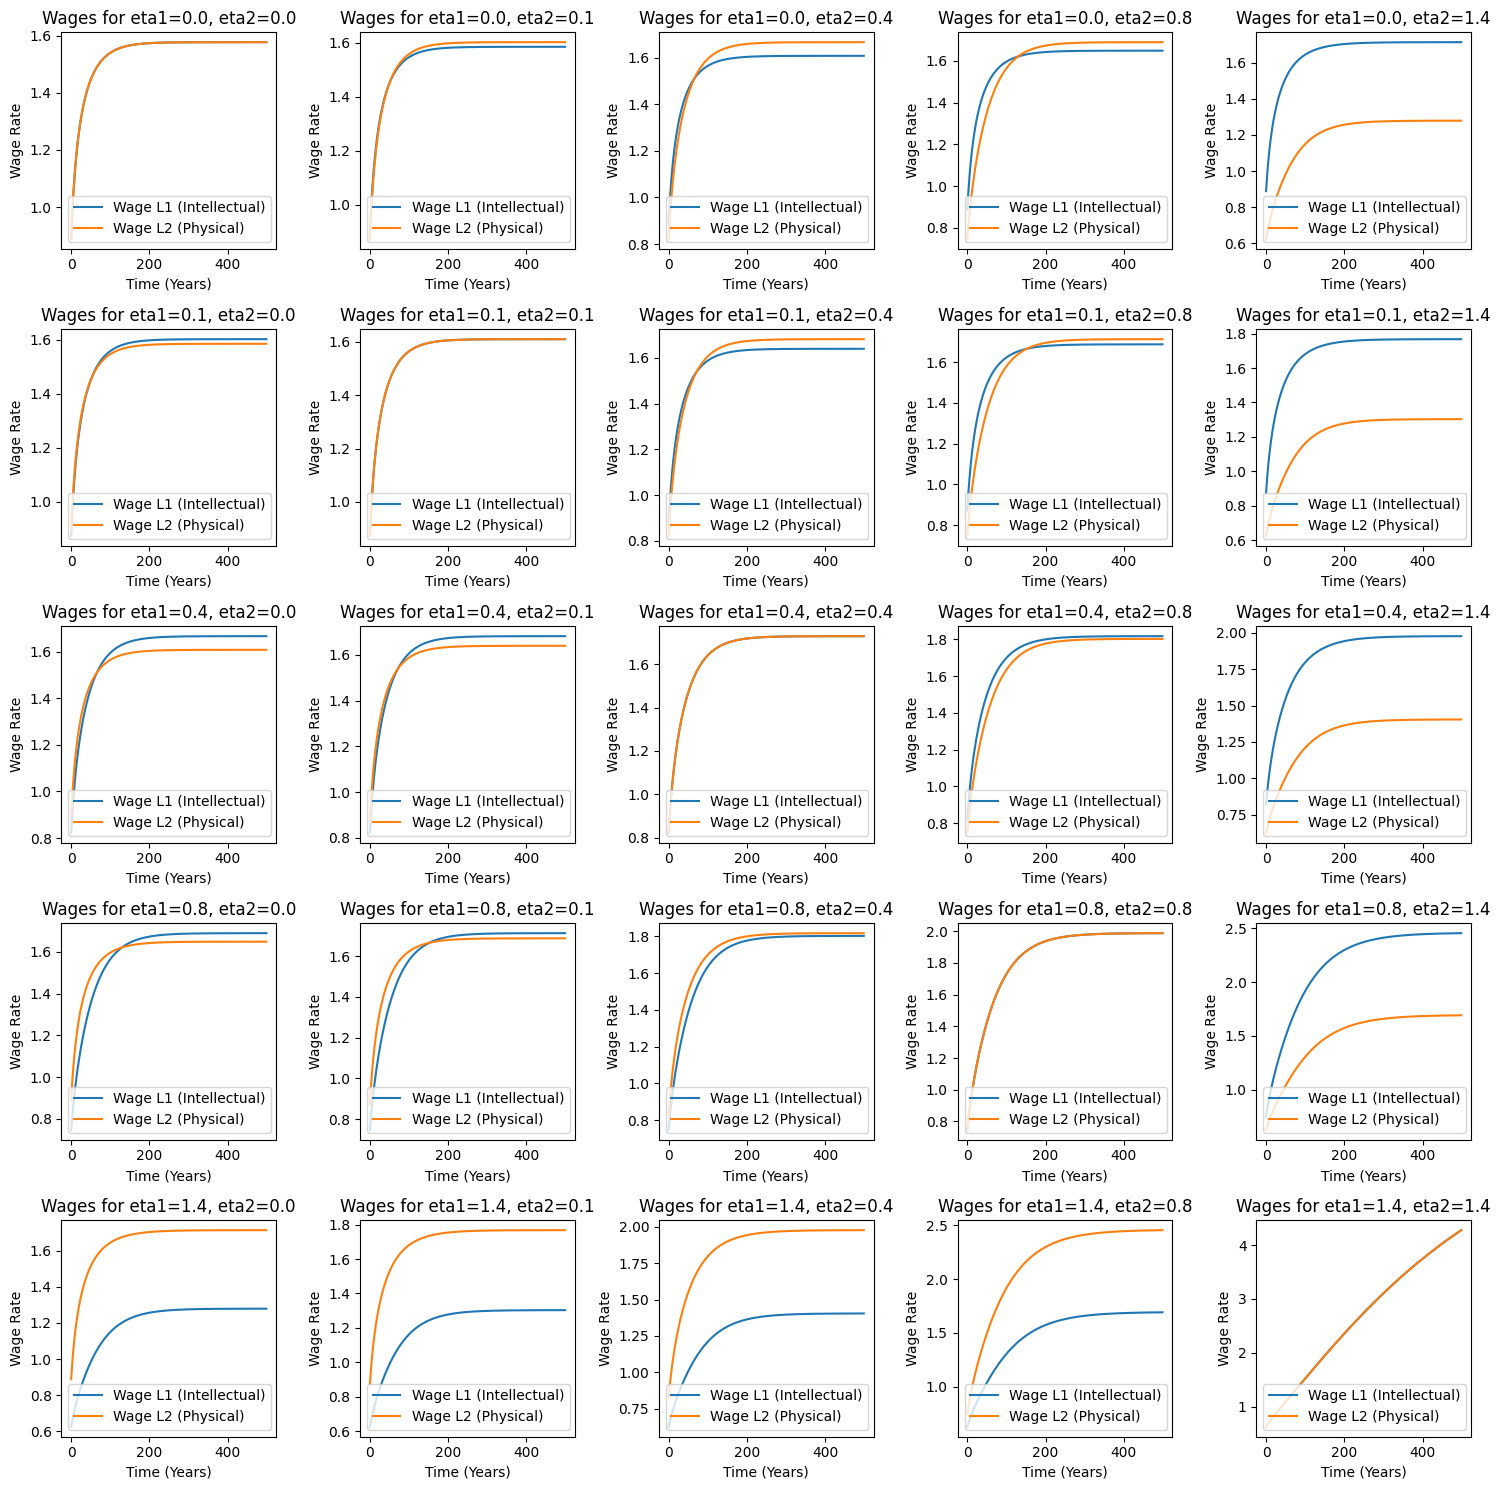

In [13]:
def test_elasticity_of_substitution(eta1_values, eta2_values, T):
    fig, ax = plt.subplots(len(eta1_values), len(eta2_values), figsize=(15, 15))
    
    # Check if we have a subplot grid or a single row/column
    if len(eta1_values) == 1 or len(eta2_values) == 1:
        ax = [ax]  # Make sure we can iterate over ax

    for i, eta1 in enumerate(eta1_values):
        for j, eta2 in enumerate(eta2_values):
            model = MacroeconomicModel(eta_1=eta1, eta_2=eta2)
            results = model.simulate(K_0=1, H_0=1, L_0=1, A_0=1, M_0=1, T=T)
            
            # Plotting the wage rates over time for each combination of eta1 and eta2
            if len(eta1_values) > 1 and len(eta2_values) > 1:
                ax_ij = ax[i, j]  # If we have a grid, select subplot
            elif len(eta1_values) > 1:
                ax_ij = ax[i]  # If we only vary eta1, select row
            else:
                ax_ij = ax[j]  # If we only vary eta2, select column

            ax_ij.plot(results['Wage Rate L1'], label='Wage L1 (Intellectual)')
            ax_ij.plot(results['Wage Rate L2'], label='Wage L2 (Physical)')
            ax_ij.set_title(f'Wages for eta1={eta1}, eta2={eta2}')
            ax_ij.set_xlabel('Time (Years)')
            ax_ij.set_ylabel('Wage Rate')
            ax_ij.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
test_elasticity_of_substitution([0.0, 0.1, 0.4, 0.8, 1.4,], [ 0.0, 0.1, 0.4, 0.8, 1.4], 500)


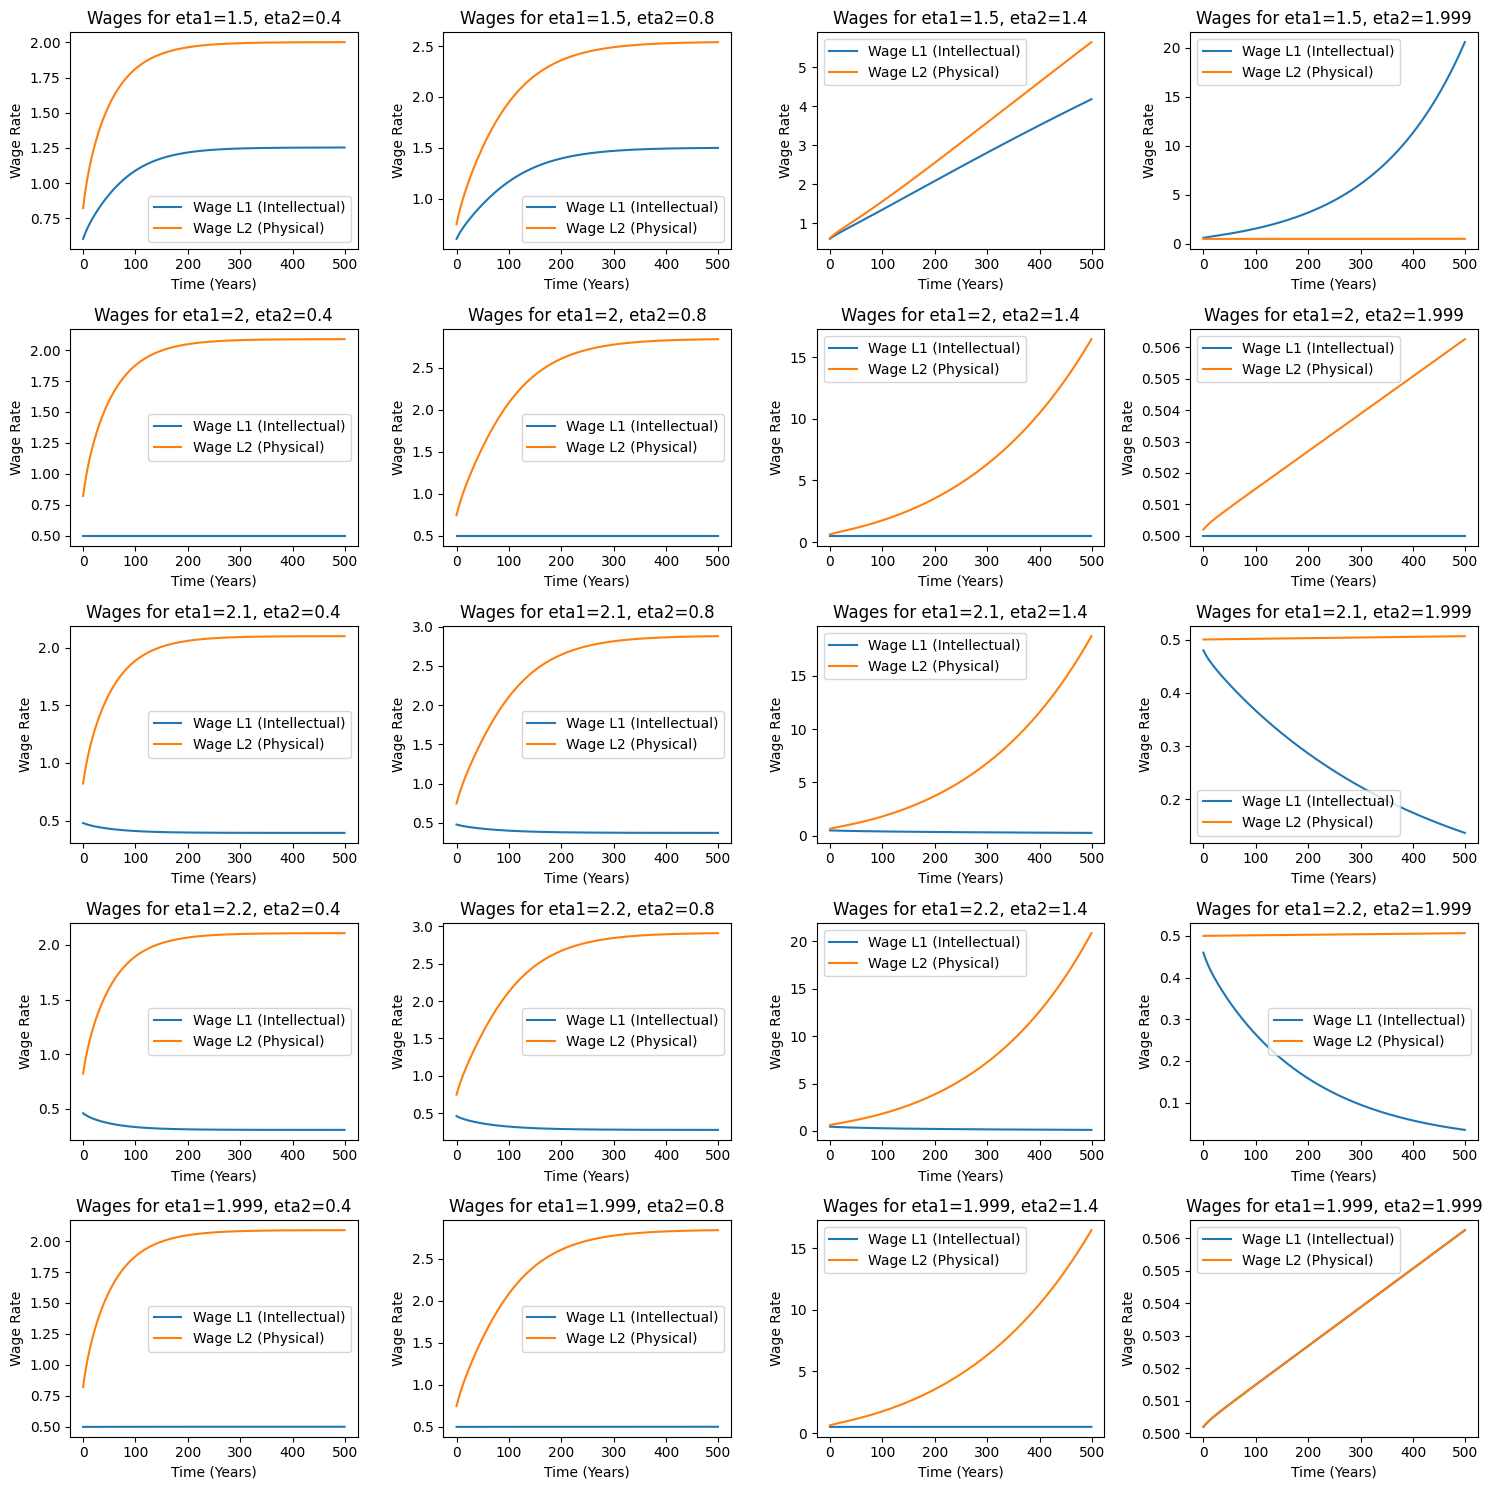

In [14]:
def test_elasticity_of_substitution(eta1_values, eta2_values, T):
    fig, ax = plt.subplots(len(eta1_values), len(eta2_values), figsize=(15, 15))
    
    # Check if we have a subplot grid or a single row/column
    if len(eta1_values) == 1 or len(eta2_values) == 1:
        ax = [ax]  # Make sure we can iterate over ax

    for i, eta1 in enumerate(eta1_values):
        for j, eta2 in enumerate(eta2_values):
            model = MacroeconomicModel(eta_1=eta1, eta_2=eta2)
            results = model.simulate(K_0=1, H_0=1, L_0=1, A_0=1, M_0=1, T=T)
            
            # Plotting the wage rates over time for each combination of eta1 and eta2
            if len(eta1_values) > 1 and len(eta2_values) > 1:
                ax_ij = ax[i, j]  # If we have a grid, select subplot
            elif len(eta1_values) > 1:
                ax_ij = ax[i]  # If we only vary eta1, select row
            else:
                ax_ij = ax[j]  # If we only vary eta2, select column

            ax_ij.plot(results['Wage Rate L1'], label='Wage L1 (Intellectual)')
            ax_ij.plot(results['Wage Rate L2'], label='Wage L2 (Physical)')
            ax_ij.set_title(f'Wages for eta1={eta1}, eta2={eta2}')
            ax_ij.set_xlabel('Time (Years)')
            ax_ij.set_ylabel('Wage Rate')
            ax_ij.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
test_elasticity_of_substitution([1.5, 2, 2.1, 2.2, 1.999], [ 0.4, 0.8, 1.4, 1.999], 500)


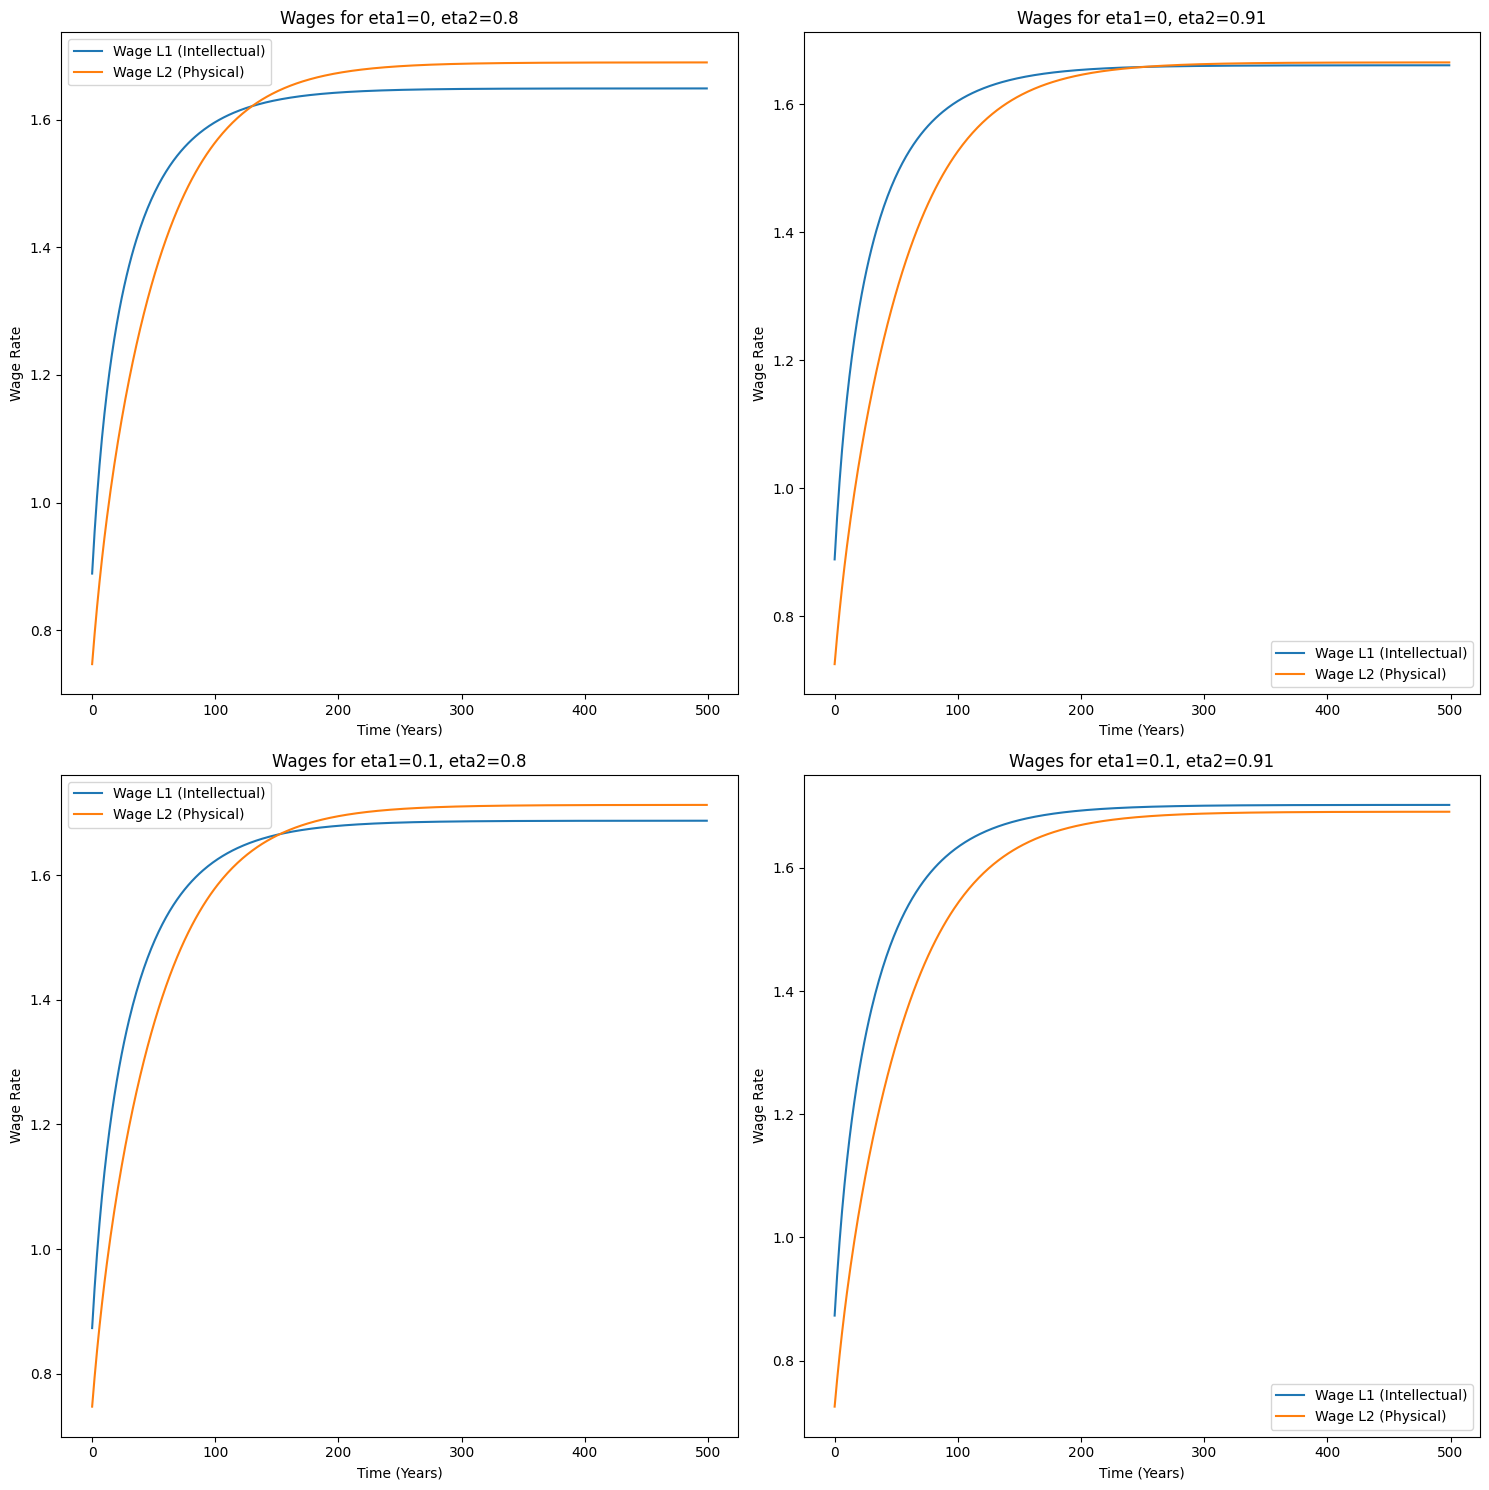

In [15]:
def test_elasticity_of_substitution(eta1_values, eta2_values, T):
    fig, ax = plt.subplots(len(eta1_values), len(eta2_values), figsize=(15, 15))
    
    # Check if we have a subplot grid or a single row/column
    if len(eta1_values) == 1 or len(eta2_values) == 1:
        ax = [ax]  # Make sure we can iterate over ax

    for i, eta1 in enumerate(eta1_values):
        for j, eta2 in enumerate(eta2_values):
            model = MacroeconomicModel(eta_1=eta1, eta_2=eta2)
            results = model.simulate(K_0=1, H_0=1, L_0=1, A_0=1, M_0=1, T=T)
            
            # Plotting the wage rates over time for each combination of eta1 and eta2
            if len(eta1_values) > 1 and len(eta2_values) > 1:
                ax_ij = ax[i, j]  # If we have a grid, select subplot
            elif len(eta1_values) > 1:
                ax_ij = ax[i]  # If we only vary eta1, select row
            else:
                ax_ij = ax[j]  # If we only vary eta2, select column

            ax_ij.plot(results['Wage Rate L1'], label='Wage L1 (Intellectual)')
            ax_ij.plot(results['Wage Rate L2'], label='Wage L2 (Physical)')
            ax_ij.set_title(f'Wages for eta1={eta1}, eta2={eta2}')
            ax_ij.set_xlabel('Time (Years)')
            ax_ij.set_ylabel('Wage Rate')
            ax_ij.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
test_elasticity_of_substitution([0, 0.1], [0.8, 0.91,], 500)


## Analyzing different levels of savins into s_M:

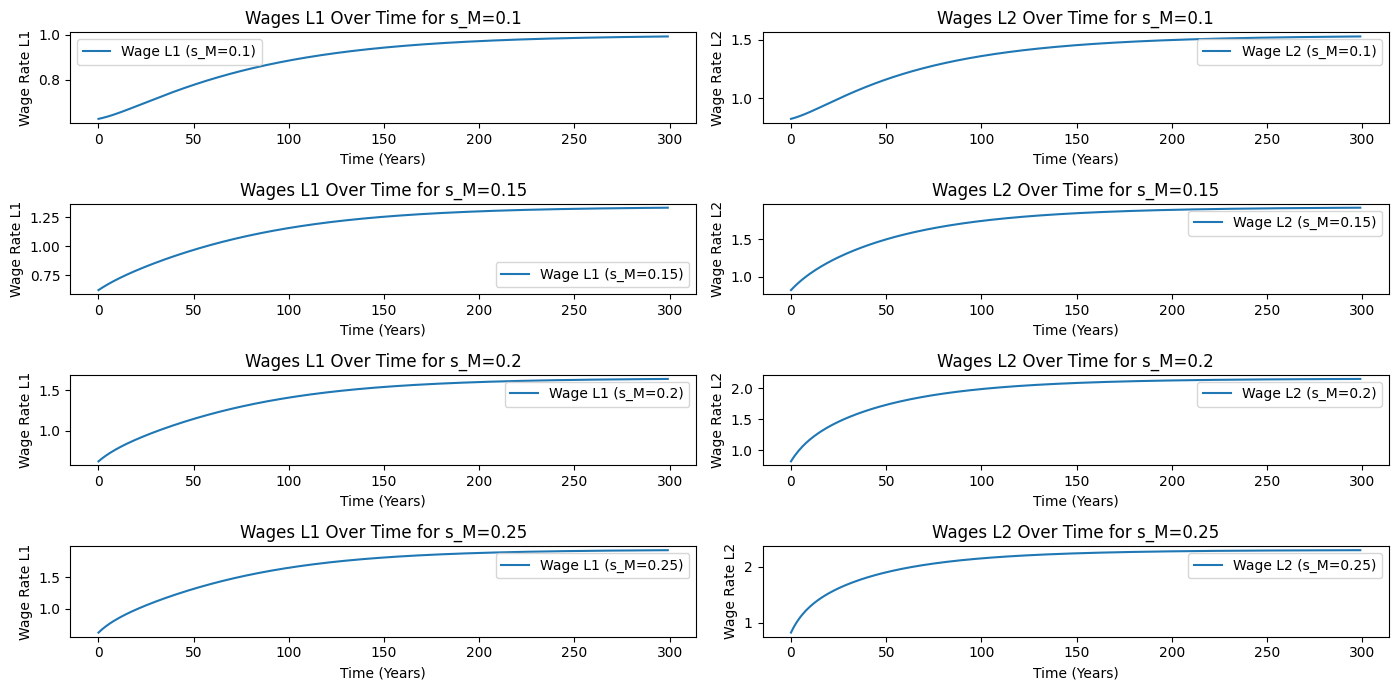

Total savings rate exceeded the cap. Adjusting s_K, s_H, and s_M to comply with the cap.
0.09999999999999998
0.09999999999999998
0.3
Total savings rate exceeded the cap. Adjusting s_K, s_H, and s_M to comply with the cap.
0.07500000000000001
0.07500000000000001
0.35
Total savings rate exceeded the cap. Adjusting s_K, s_H, and s_M to comply with the cap.
0.04999999999999999
0.04999999999999999
0.4
Total savings rate exceeded the cap. Adjusting s_K, s_H, and s_M to comply with the cap.
0.025000000000000022
0.025000000000000022
0.45


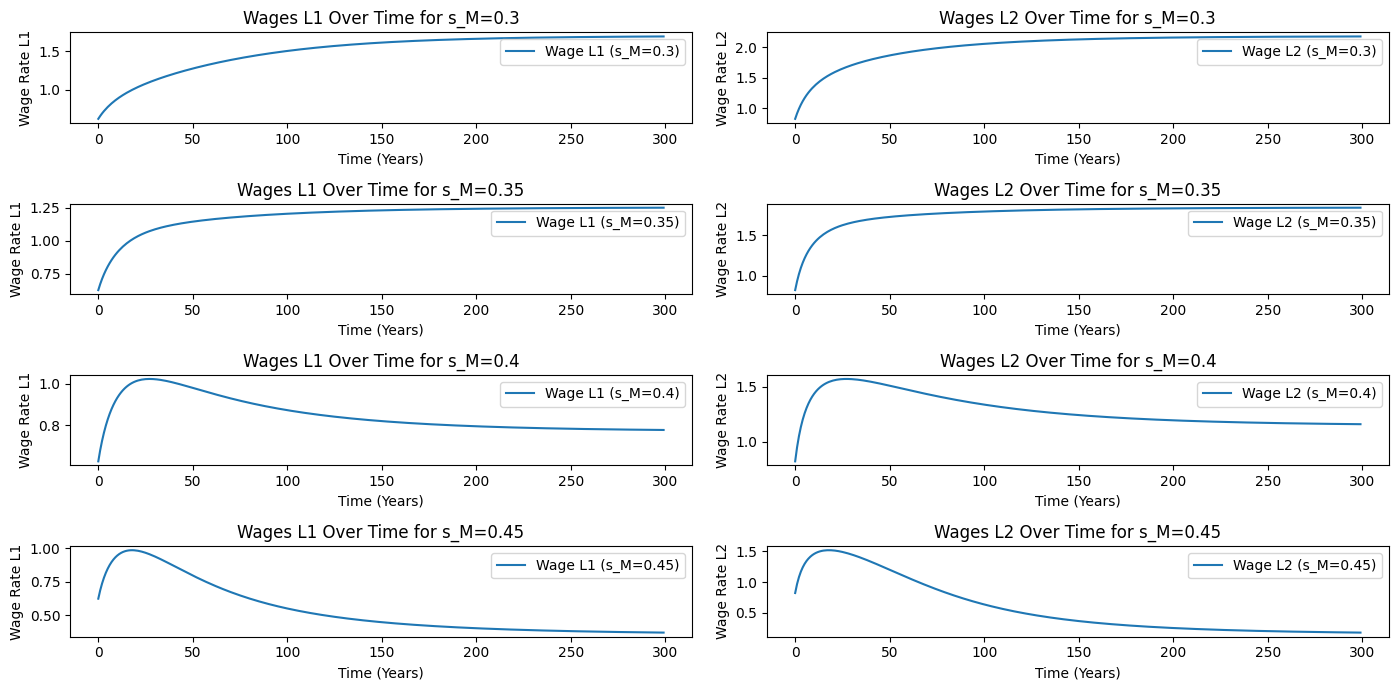

In [16]:
def test_savings_rate_sensitivity(s_M_values, T):
    plt.figure(figsize=(14, 7))
    for idx, s_M in enumerate(s_M_values):
        model = MacroeconomicModel(s_M=s_M)
        results = model.simulate(K_0=1, H_0=1, L_0=1, A_0=1, M_0=1, T=300)

        # Plotting the wage rates for L1 and L2 for each s_M value
        plt.subplot(len(s_M_values), 2, 2*idx + 1)
        plt.plot(results.index, results['Wage Rate L1'], label=f'Wage L1 (s_M={s_M})')
        plt.title(f'Wages L1 Over Time for s_M={s_M}')
        plt.xlabel('Time (Years)')
        plt.ylabel('Wage Rate L1')
        plt.legend()

        plt.subplot(len(s_M_values), 2, 2*idx + 2)
        plt.plot(results.index, results['Wage Rate L2'], label=f'Wage L2 (s_M={s_M})')
        plt.title(f'Wages L2 Over Time for s_M={s_M}')
        plt.xlabel('Time (Years)')
        plt.ylabel('Wage Rate L2')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
s_M_values = [0.10, 0.15, 0.20, 0.25]  # Define a range of s_M values
T = 100  # Define the simulation period
test_savings_rate_sensitivity(s_M_values, T)

s_M_values = [0.30, 0.35, 0.40, 0.45]  # Define a range of s_M values
T = 100  # Define the simulation period
test_savings_rate_sensitivity(s_M_values, T)



# Long-Term Trends Test growth speed:

In [17]:
def test_long_term_trends(T):
    model = MacroeconomicModel()
    results = model.simulate(K_0=1, H_0=1, L_0=1, A_0=1, M_0=1, T=T)
    # analyze the long term trends
    

In [18]:
# Run the simulation for a very long time
model = MacroeconomicModel()
results = model.simulate(K_0=1, H_0=1, L_0=1, A_0=1, M_0=1, T=10001)

# Calculate growth rates at year 20 and year 10000
growth_rate_year_20 = (results['Output'][20] / results['Output'][19]) - 1
growth_rate_year_alot = (results['Output'][10000] / results['Output'][9999]) - 1

# Compare growth rates
speed_difference = growth_rate_year_20 / growth_rate_year_alot

# Calculate the annual change as CAGR
years_elapsed = 10000 - 20
CAGR = ((growth_rate_year_alot / growth_rate_year_20)**(1 / years_elapsed)) - 1

# Output the results
print(f"Growth rate at year 20: {growth_rate_year_20}")
print(f"Growth rate at years alot: {growth_rate_year_alot}")
print(f"Speed difference: {speed_difference}")
print(f"Annual change in growth rate (CAGR): {CAGR}")


Growth rate at year 20: 0.04887528521124662
Growth rate at years alot: 0.030199999999999783
Speed difference: 1.6183869275247342
Annual change in growth rate (CAGR): -4.823830838229792e-05


# Economy simulation without Any AI Present


Per Capita Growth Rate for Output in the last 5 years: 368    0.020001
369    0.020001
370    0.020001
371    0.020001
372    0.020000
Name: Y_growth_pc, dtype: float64
Per Capita Growth Rate for Capital in the last 5 years: 368    0.020001
369    0.020001
370    0.020001
371    0.020001
372    0.020001
Name: K_growth_pc, dtype: float64
Per Capita Growth Rate for Human Capital in the last 5 years: 368    0.020001
369    0.020001
370    0.020001
371    0.020001
372    0.020001
Name: H_growth_pc, dtype: float64


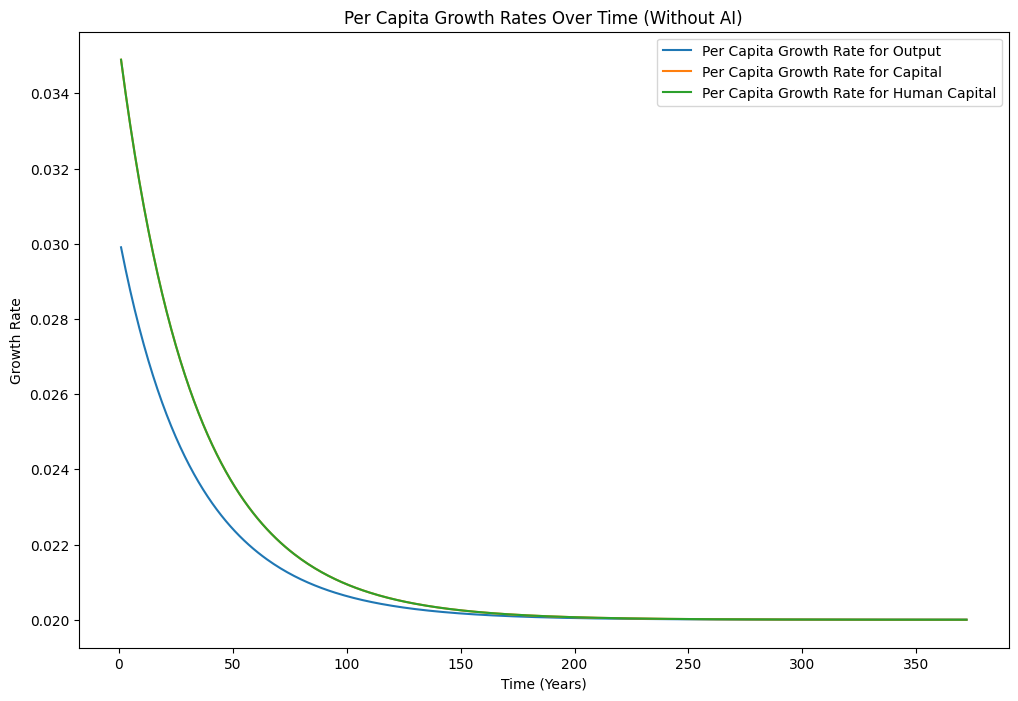

Per Capita Growth Rate for Output exactly hit 0.02 in year 345.


In [19]:
def simulate_without_ai(model, K_0, H_0, L_0, A_0, T):
    # Backup original AI-related parameters
    original_params = {
        's_M': model.s_M,
        'eta_1': model.eta_1,
        'eta_2': model.eta_2,
        'eta_3': model.eta_3,
        'alpha_12': model.alpha_12,
        'alpha_22': model.alpha_22,
        'alpha_31': model.alpha_31,
        'alpha_32': model.alpha_32
    }

    # Set AI-related parameters to neutral values to simulate without AI
    model.s_M = 0
    model.eta_1 = 1
    model.eta_2 = 1
    model.eta_3 = 1
    model.alpha_12 = 0  # Setting AI share parameters to 0
    model.alpha_22 = 0
    model.alpha_31 = 0.5  # Assuming L_1 and L_2 have equal share in effective labor when AI is not considered
    model.alpha_32 = 0.5

    # Run the simulation without AI
    results_without_ai = model.simulate(K_0, H_0, L_0, A_0, 0, T)  # Set AI level (M_0) to zero

     # Restore original AI-related parameters
    for param, value in original_params.items():
        setattr(model, param, value)

    # Convert results to a DataFrame for easier manipulation
    results_df = pd.DataFrame(results_without_ai)
    
    # Calculate growth rates per capita
    results_df['Y_growth_pc'] = (results_df['Output'] / results_df['Labor']).pct_change().fillna(0)
    results_df['K_growth_pc'] = (results_df['Capital'] / results_df['Labor']).pct_change().fillna(0)
    results_df['H_growth_pc'] = (results_df['Human Capital'] / results_df['Labor']).pct_change().fillna(0)
  
    
    # Print the growth rates for the last 5 years per capita
    print("Per Capita Growth Rate for Output in the last 5 years:", results_df['Y_growth_pc'][-5:])
    print("Per Capita Growth Rate for Capital in the last 5 years:", results_df['K_growth_pc'][-5:])
    print("Per Capita Growth Rate for Human Capital in the last 5 years:", results_df['H_growth_pc'][-5:])

  
    
    
    # Plot growth rates per capita
    plt.figure(figsize=(12, 8))
    plt.plot(results_df.index[1:], results_df['Y_growth_pc'][1:], label='Per Capita Growth Rate for Output')  # Start from index 1
    plt.plot(results_df.index[1:], results_df['K_growth_pc'][1:], label='Per Capita Growth Rate for Capital')  # Start from index 1
    plt.plot(results_df.index[1:], results_df['H_growth_pc'][1:], label='Per Capita Growth Rate for Human Capital')  # Start from index 1
    
    plt.title('Per Capita Growth Rates Over Time (Without AI)')
    plt.xlabel('Time (Years)')
    plt.ylabel('Growth Rate')
    plt.legend()
    plt.show()
    
    # Add code to find the first year when Y_growth_pc is exactly 0.02
    target_growth_rate = 0.020
    tolerance = 1e-6  # A small tolerance for floating-point comparison
    year_of_exact_target_growth = None
    for index, growth_rate in results_df['Y_growth_pc'].iteritems():  # Use iteritems to get the index and value
        if abs(growth_rate - target_growth_rate) < tolerance:
            year_of_exact_target_growth = index  # index here corresponds to the year in the simulation
            break

    # Check if the target growth rate was exactly met within the simulation period
    if year_of_exact_target_growth is not None:
        print(f"Per Capita Growth Rate for Output exactly hit {target_growth_rate} in year {year_of_exact_target_growth}.")
    else:
        print(f"Per Capita Growth Rate for Output did not exactly hit {target_growth_rate} within the simulation period.")


    # Return results
    return results_df

# Create an instance of the model
model = MacroeconomicModel()

# Run the simulation without AI for a long term
long_term_T = 373




results_without_ai_df = simulate_without_ai(model, K_0=1, H_0=1, L_0=1, A_0=1, T=long_term_T)



Average growth rate without AI: 0.02052549204679026
Average growth rate with AI: 0.0222494371217301


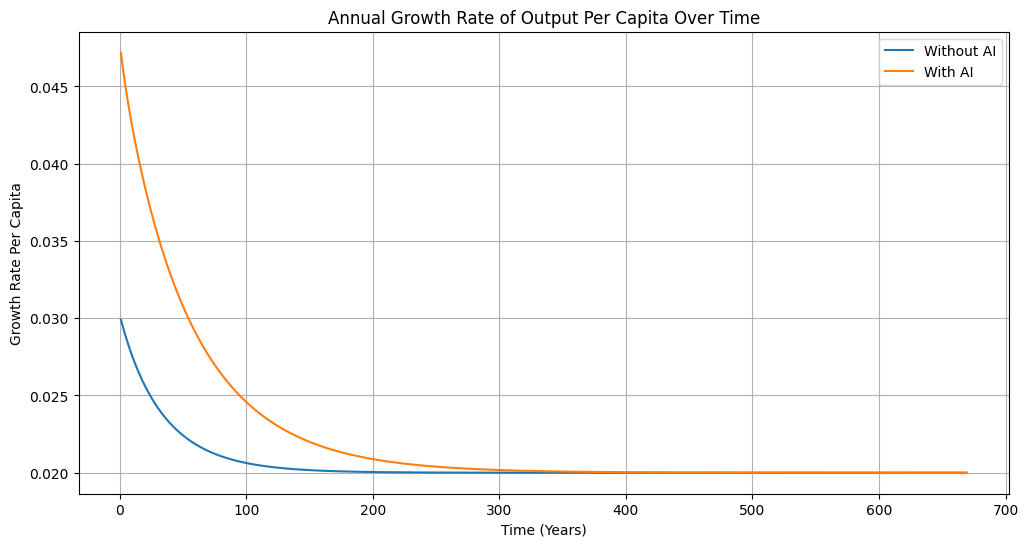

Average per capita growth rate from year 0 to 50 without AI: 0.0253
Average per capita growth rate from year 0 to 50 with AI: 0.0376

Average per capita growth rate from year 50 to 100 without AI: 0.0213
Average per capita growth rate from year 50 to 100 with AI: 0.0273

Average per capita growth rate from year 100 to 150 without AI: 0.0204
Average per capita growth rate from year 100 to 150 with AI: 0.0231

Average per capita growth rate from year 0 to 150 without AI: 0.0223
Average per capita growth rate from year 0 to 150 with AI: 0.0293

Average per capita growth rate from year 500 to 1000 without AI: 0.0200
Average per capita growth rate from year 500 to 1000 with AI: 0.0200



In [20]:
# Create an instance of the model without AI
model_without_ai = MacroeconomicModel(s_M=0)
results_without_ai = model_without_ai.simulate(K_0=1, H_0=1, L_0=1, A_0=1, M_0=0, T=670)

# Convert to DataFrame
df_without_ai = pd.DataFrame(results_without_ai)

# Calculate per capita output
df_without_ai['Output_per_capita'] = df_without_ai['Output'] / df_without_ai['Labor']

# Analyze the growth rate without AI
growth_rate_without_ai = df_without_ai['Output_per_capita'].pct_change().mean()

# Create an instance of the model with AI
model_with_ai = MacroeconomicModel(s_M=0.16)
results_with_ai = model_with_ai.simulate(K_0=1, H_0=1, L_0=1, A_0=1, M_0=1, T=670)

# Convert to DataFrame
df_with_ai = pd.DataFrame(results_with_ai)

# Calculate per capita output
df_with_ai['Output_per_capita'] = df_with_ai['Output'] / df_with_ai['Labor']

# Analyze the growth rate with AI
growth_rate_with_ai = df_with_ai['Output_per_capita'].pct_change().mean()

# Print the average growth rates
print(f"Average growth rate without AI: {growth_rate_without_ai}")
print(f"Average growth rate with AI: {growth_rate_with_ai}")




# Plot the growth rates per capita
plt.figure(figsize=(12, 6))
plt.plot(df_without_ai.index, df_without_ai['Output_per_capita'].pct_change(), label='Without AI')
plt.plot(df_with_ai.index, df_with_ai['Output_per_capita'].pct_change(), label='With AI')
plt.title('Annual Growth Rate of Output Per Capita Over Time')
plt.xlabel('Time (Years)')
plt.ylabel('Growth Rate Per Capita')
plt.legend()
plt.grid(True)
plt.show()


def calculate_average_growth_rate_per_capita(results, start_year, end_year):
    """Calculate average per capita growth rate between specified years."""
    results['Output_per_capita'] = results['Output'] / results['Labor']
    growth_rate_per_capita = results['Output_per_capita'].pct_change()
    average_growth_per_capita = growth_rate_per_capita[start_year:end_year].mean()
    return average_growth_per_capita

# Assuming 'results_without_ai' and 'results_with_ai' are DataFrames containing your simulation results
time_intervals = [(0, 50), (50, 100), (100, 150), (0, 150), (500,1000)]  # Define your intervals

for start, end in time_intervals:
    avg_growth_without_ai = calculate_average_growth_rate_per_capita(results_without_ai, start, end)
    avg_growth_with_ai = calculate_average_growth_rate_per_capita(results_with_ai, start, end)

    print(f"Average per capita growth rate from year {start} to {end} without AI: {avg_growth_without_ai:.4f}")
    print(f"Average per capita growth rate from year {start} to {end} with AI: {avg_growth_with_ai:.4f}\n")


    
    



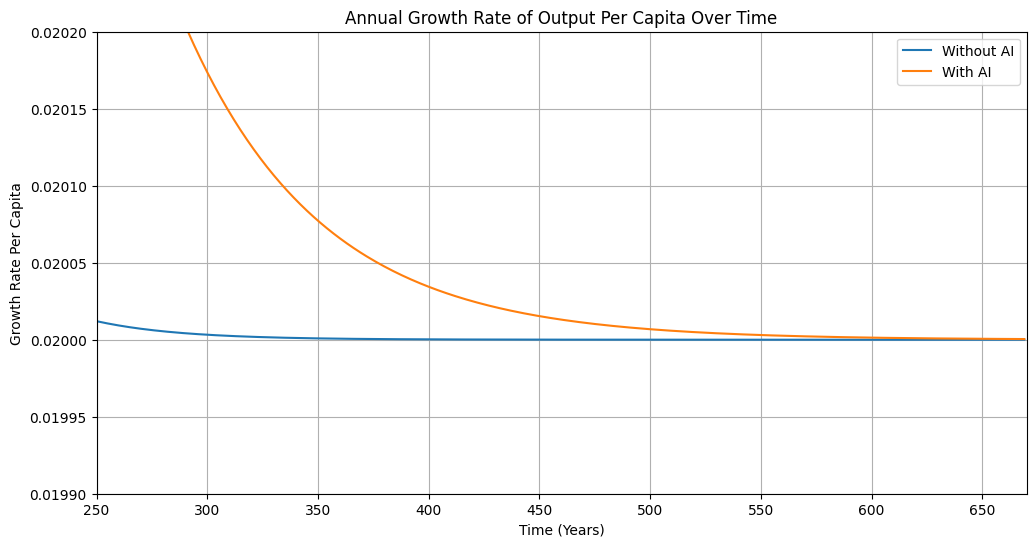

In [21]:
# Plot the growth rates per capita
plt.figure(figsize=(12, 6))
plt.plot(df_without_ai.index, df_without_ai['Output_per_capita'].pct_change(), label='Without AI')
plt.plot(df_with_ai.index, df_with_ai['Output_per_capita'].pct_change(), label='With AI')
plt.title('Annual Growth Rate of Output Per Capita Over Time')
plt.xlabel('Time (Years)')
plt.ylabel('Growth Rate Per Capita')
plt.ylim(0.0199, 0.0202)
plt.xlim(250, 670)
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Calculate the difference from target growth rate for each model
# df_without_ai['Distance_from_Target'] = df_without_ai['Output_per_capita'].pct_change().apply(lambda x: abs(x - 0.02))
# df_with_ai['Distance_from_Target'] = df_with_ai['Output_per_capita'].pct_change().apply(lambda x: abs(x - 0.02))

# # Plot the distances from the target growth rate
# plt.figure(figsize=(12, 6))
# plt.plot(df_without_ai.index, df_without_ai['Distance_from_Target'], label='Without AI')
# plt.plot(df_with_ai.index, df_with_ai['Distance_from_Target'], label='With AI')
# plt.title('Distance from Target Annual Growth Rate of Output Per Capita Over Time')
# plt.xlabel('Time (Years)')
# plt.ylabel('Distance from 0.02 Growth Rate')
# plt.legend()
# plt.grid(True)
# plt.show()



In [23]:

# Calculate the rate of change of the distance from the target
# df_without_ai['Rate_of_Change_in_Distance'] = df_without_ai['Distance_from_Target'].pct_change().fillna(0)
# df_with_ai['Rate_of_Change_in_Distance'] = df_with_ai['Distance_from_Target'].pct_change().fillna(0)

# # Plot the rate of change of the distance from the target growth rate
# plt.figure(figsize=(12, 6))
# plt.plot(df_without_ai.index, df_without_ai['Rate_of_Change_in_Distance'], label='Rate of Change Without AI')
# plt.plot(df_with_ai.index, df_with_ai['Rate_of_Change_in_Distance'], label='Rate of Change With AI')
# plt.title('Rate of Change in Distance from Target Growth Rate Per Capita Over Time')
# plt.xlabel('Time (Years)')
# plt.ylabel('Rate of Change in Distance')
# plt.legend()
# plt.grid(True)
# plt.show()


In [24]:
# def test_shock(shock_time, shock_magnitude, T):
#     model = MacroeconomicModel()
#     pre_shock_results = model.simulate(K_0=1, H_0=1, L_0=1, A_0=1, M_0=1, T=shock_time)

#     # Apply shock directly in the simulation parameters
#     shocked_M_0 = pre_shock_results['AI'].iloc[-1] + shock_magnitude  # Use .iloc[-1] to get the last element
#     post_shock_results = model.simulate(K_0=pre_shock_results['Capital'].iloc[-1], 
#                                         H_0=pre_shock_results['Human Capital'].iloc[-1],
#                                         L_0=pre_shock_results['Labor'].iloc[-1], 
#                                         A_0=pre_shock_results['Technology'].iloc[-1],
#                                         M_0=shocked_M_0, T=T-shock_time)

#     # Combine pre-shock and post-shock results
#     combined_results = pd.concat([pre_shock_results, post_shock_results])

#     if combined_results.empty:
#         print("Error: The combined DataFrame is empty.")
#         return

#     # Plot the results
#     plt.figure(figsize=(14, 7))

#     # Plot Total Output
#     plt.subplot(2, 2, 1)
#     plt.plot(combined_results.index, combined_results['Output'], label='Total Output')
#     plt.axvline(x=shock_time, color='r', linestyle='--', label='Shock Time')
#     plt.title('Total Output Over Time')
#     plt.xlabel('Time (Years)')
#     plt.ylabel('Output')
#     plt.legend()

#     # Plot AI Level
#     plt.subplot(2, 2, 2)
#     plt.plot(combined_results.index, combined_results['AI'], label='AI Level')
#     plt.axvline(x=shock_time, color='r', linestyle='--', label='Shock Time')
#     plt.title('AI Level Over Time')
#     plt.xlabel('Time (Years)')
#     plt.ylabel('AI Level')
#     plt.legend()

#     # Plot Wage Rate for L1
#     plt.subplot(2, 2, 3)
#     plt.plot(combined_results.index, combined_results['Wage Rate L1'], label='Wage Rate L1')
#     plt.axvline(x=shock_time, color='r', linestyle='--', label='Shock Time')
#     plt.title('Wage Rate L1 Over Time')
#     plt.xlabel('Time (Years)')
#     plt.ylabel('Wage Rate L1')
#     plt.legend()

#     # Plot Wage Rate for L2
#     plt.subplot(2, 2, 4)
#     plt.plot(combined_results.index, combined_results['Wage Rate L2'], label='Wage Rate L2')
#     plt.axvline(x=shock_time, color='r', linestyle='--', label='Shock Time')
#     plt.title('Wage Rate L2 Over Time')
#     plt.xlabel('Time (Years)')
#     plt.ylabel('Wage Rate L2')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# # Example usage
# test_shock(20, 0.5, 100)